# COVSMA
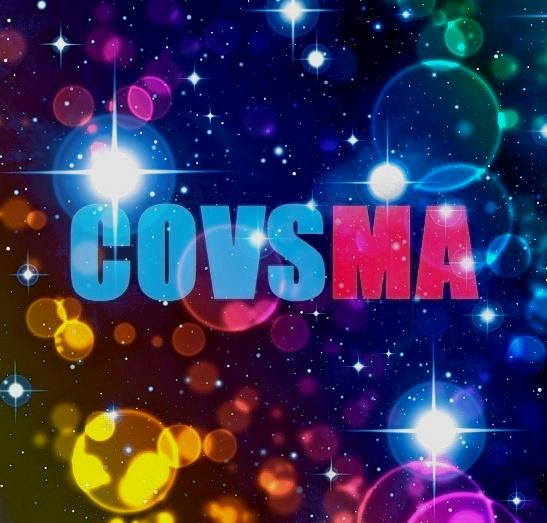

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#COVSMA" data-toc-modified-id="COVSMA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>COVSMA</a></span></li><li><span><a href="#COVSMA's-first-tool:-COVSCO" data-toc-modified-id="COVSMA's-first-tool:-COVSCO-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>COVSMA's first tool: COVSCO</a></span><ul class="toc-item"><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data Exploration</a></span><ul class="toc-item"><li><span><a href="#Introduction-to-the-data:-our-X,-our-y" data-toc-modified-id="Introduction-to-the-data:-our-X,-our-y-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Introduction to the data: our X, our y</a></span><ul class="toc-item"><li><span><a href="#The-features:-22-variables-from-which-we-will-predict-our-target" data-toc-modified-id="The-features:-22-variables-from-which-we-will-predict-our-target-2.1.1.1"><span class="toc-item-num">2.1.1.1&nbsp;&nbsp;</span>The features: 22 variables from which we will predict our target</a></span></li><li><span><a href="#The-Target:-New-hospitalizations-due-to-severe-COVID19-cases" data-toc-modified-id="The-Target:-New-hospitalizations-due-to-severe-COVID19-cases-2.1.1.2"><span class="toc-item-num">2.1.1.2&nbsp;&nbsp;</span>The Target: New hospitalizations due to severe COVID19 cases</a></span></li></ul></li><li><span><a href="#New-hospitalizations-means-over-all-departements-as-a-function-of-7davg-pollutants-concentrations-differencials" data-toc-modified-id="New-hospitalizations-means-over-all-departements-as-a-function-of-7davg-pollutants-concentrations-differencials-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>New hospitalizations means over all departements as a function of 7davg pollutants concentrations differencials</a></span></li><li><span><a href="#New-hospitalizations-means-over-all-departements-as-a-function-of-1Mavg---Pollutants-concentrations-differencials" data-toc-modified-id="New-hospitalizations-means-over-all-departements-as-a-function-of-1Mavg---Pollutants-concentrations-differencials-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>New hospitalizations means over all departements as a function of 1Mavg - Pollutants concentrations differencials</a></span></li><li><span><a href="#New-hospitalizations-means-over-all-departements-as-a-function-of-1MMax-Pollutants-concentrations-differencials" data-toc-modified-id="New-hospitalizations-means-over-all-departements-as-a-function-of-1MMax-Pollutants-concentrations-differencials-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>New hospitalizations means over all departements as a function of 1MMax Pollutants concentrations differencials</a></span></li><li><span><a href="#Ozone-(O3)-and-the-number-of-severe-COVID19-cases-leading-to-hospitalization" data-toc-modified-id="Ozone-(O3)-and-the-number-of-severe-COVID19-cases-leading-to-hospitalization-2.1.5"><span class="toc-item-num">2.1.5&nbsp;&nbsp;</span>Ozone (O3) and the number of severe COVID19 cases leading to hospitalization</a></span><ul class="toc-item"><li><span><a href="#Departement-75:-Paris-region-Ile-de-France" data-toc-modified-id="Departement-75:-Paris-region-Ile-de-France-2.1.5.1"><span class="toc-item-num">2.1.5.1&nbsp;&nbsp;</span>Departement 75: Paris region Ile de France</a></span></li><li><span><a href="#Departement-83:-Var-region-PACA" data-toc-modified-id="Departement-83:-Var-region-PACA-2.1.5.2"><span class="toc-item-num">2.1.5.2&nbsp;&nbsp;</span>Departement 83: Var region PACA</a></span></li></ul></li><li><span><a href="#Nitrogen-dioxide-(NO2)-and-the-number-of-severe-COVID19-cases-leading-to-hospitalization" data-toc-modified-id="Nitrogen-dioxide-(NO2)-and-the-number-of-severe-COVID19-cases-leading-to-hospitalization-2.1.6"><span class="toc-item-num">2.1.6&nbsp;&nbsp;</span>Nitrogen dioxide (NO2) and the number of severe COVID19 cases leading to hospitalization</a></span><ul class="toc-item"><li><span><a href="#Departement-75:-Paris-region-Ile-de-France" data-toc-modified-id="Departement-75:-Paris-region-Ile-de-France-2.1.6.1"><span class="toc-item-num">2.1.6.1&nbsp;&nbsp;</span>Departement 75: Paris region Ile de France</a></span></li><li><span><a href="#Departement-83:-Var-region-PACA" data-toc-modified-id="Departement-83:-Var-region-PACA-2.1.6.2"><span class="toc-item-num">2.1.6.2&nbsp;&nbsp;</span>Departement 83: Var region PACA</a></span></li></ul></li><li><span><a href="#PM2.5-and-the-number-of-severe-COVID19-cases-leading-to-hospitalization" data-toc-modified-id="PM2.5-and-the-number-of-severe-COVID19-cases-leading-to-hospitalization-2.1.7"><span class="toc-item-num">2.1.7&nbsp;&nbsp;</span>PM2.5 and the number of severe COVID19 cases leading to hospitalization</a></span><ul class="toc-item"><li><span><a href="#Departement-75:-Paris-region-Ile-de-France" data-toc-modified-id="Departement-75:-Paris-region-Ile-de-France-2.1.7.1"><span class="toc-item-num">2.1.7.1&nbsp;&nbsp;</span>Departement 75: Paris region Ile de France</a></span></li><li><span><a href="#Departement-93:-Seine-Saint-Denis-région-Île-de-France" data-toc-modified-id="Departement-93:-Seine-Saint-Denis-région-Île-de-France-2.1.7.2"><span class="toc-item-num">2.1.7.2&nbsp;&nbsp;</span>Departement 93: Seine Saint-Denis région Île-de-France</a></span></li><li><span><a href="#Departement-83:-Var-region-PACA" data-toc-modified-id="Departement-83:-Var-region-PACA-2.1.7.3"><span class="toc-item-num">2.1.7.3&nbsp;&nbsp;</span>Departement 83: Var region PACA</a></span></li><li><span><a href="#Departement21:-Côte-d'Or" data-toc-modified-id="Departement21:-Côte-d'Or-2.1.7.4"><span class="toc-item-num">2.1.7.4&nbsp;&nbsp;</span>Departement21: Côte d'Or</a></span></li></ul></li><li><span><a href="#CO-and-the-number-of-severe-COVID19-cases-leading-to-hospitalization" data-toc-modified-id="CO-and-the-number-of-severe-COVID19-cases-leading-to-hospitalization-2.1.8"><span class="toc-item-num">2.1.8&nbsp;&nbsp;</span>CO and the number of severe COVID19 cases leading to hospitalization</a></span><ul class="toc-item"><li><span><a href="#Departement-75:-Paris-region-Ile-de-France" data-toc-modified-id="Departement-75:-Paris-region-Ile-de-France-2.1.8.1"><span class="toc-item-num">2.1.8.1&nbsp;&nbsp;</span>Departement 75: Paris region Ile de France</a></span></li></ul></li><li><span><a href="#SO2-and-the-number-of-severe-COVID19-cases-leading-to-hospitalization" data-toc-modified-id="SO2-and-the-number-of-severe-COVID19-cases-leading-to-hospitalization-2.1.9"><span class="toc-item-num">2.1.9&nbsp;&nbsp;</span>SO2 and the number of severe COVID19 cases leading to hospitalization</a></span></li><li><span><a href="#The-most-polluted-departements-of-France" data-toc-modified-id="The-most-polluted-departements-of-France-2.1.10"><span class="toc-item-num">2.1.10&nbsp;&nbsp;</span>The most polluted departements of France</a></span><ul class="toc-item"><li><span><a href="#The-Ozone-O3-Pollutant" data-toc-modified-id="The-Ozone-O3-Pollutant-2.1.10.1"><span class="toc-item-num">2.1.10.1&nbsp;&nbsp;</span>The Ozone O3 Pollutant</a></span></li><li><span><a href="#The-PM2.5-Pollutant" data-toc-modified-id="The-PM2.5-Pollutant-2.1.10.2"><span class="toc-item-num">2.1.10.2&nbsp;&nbsp;</span>The PM2.5 Pollutant</a></span></li><li><span><a href="#The-NO2-Pollutant" data-toc-modified-id="The-NO2-Pollutant-2.1.10.3"><span class="toc-item-num">2.1.10.3&nbsp;&nbsp;</span>The NO2 Pollutant</a></span></li><li><span><a href="#The-CO-Pollutant" data-toc-modified-id="The-CO-Pollutant-2.1.10.4"><span class="toc-item-num">2.1.10.4&nbsp;&nbsp;</span>The CO Pollutant</a></span></li><li><span><a href="#The-PM10-Pollutant" data-toc-modified-id="The-PM10-Pollutant-2.1.10.5"><span class="toc-item-num">2.1.10.5&nbsp;&nbsp;</span>The PM10 Pollutant</a></span></li></ul></li><li><span><a href="#The-facebook-mobility-index" data-toc-modified-id="The-facebook-mobility-index-2.1.11"><span class="toc-item-num">2.1.11&nbsp;&nbsp;</span>The facebook mobility index</a></span><ul class="toc-item"><li><span><a href="#The-facebook-mobility-index-VS-Ozone-O3" data-toc-modified-id="The-facebook-mobility-index-VS-Ozone-O3-2.1.11.1"><span class="toc-item-num">2.1.11.1&nbsp;&nbsp;</span>The facebook mobility index VS Ozone O3</a></span></li><li><span><a href="#The-facebook-mobility-index-VS-Carbon-Monoxyde-CO" data-toc-modified-id="The-facebook-mobility-index-VS-Carbon-Monoxyde-CO-2.1.11.2"><span class="toc-item-num">2.1.11.2&nbsp;&nbsp;</span>The facebook mobility index VS Carbon Monoxyde CO</a></span></li><li><span><a href="#The-facebook-mobility-index-VS-Nitrogen-Dioxide-NO2" data-toc-modified-id="The-facebook-mobility-index-VS-Nitrogen-Dioxide-NO2-2.1.11.3"><span class="toc-item-num">2.1.11.3&nbsp;&nbsp;</span>The facebook mobility index VS Nitrogen Dioxide NO2</a></span></li><li><span><a href="#The-facebook-mobility-index-VS-PM2.5" data-toc-modified-id="The-facebook-mobility-index-VS-PM2.5-2.1.11.4"><span class="toc-item-num">2.1.11.4&nbsp;&nbsp;</span>The facebook mobility index VS PM2.5</a></span></li><li><span><a href="#The-facebook-mobility-index-VS-PM10" data-toc-modified-id="The-facebook-mobility-index-VS-PM10-2.1.11.5"><span class="toc-item-num">2.1.11.5&nbsp;&nbsp;</span>The facebook mobility index VS PM10</a></span></li></ul></li></ul></li><li><span><a href="#Training-the-model---Gradient-Boosting-for-regression" data-toc-modified-id="Training-the-model---Gradient-Boosting-for-regression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Training the model - Gradient Boosting for regression</a></span><ul class="toc-item"><li><span><a href="#Hold-out-and-Cross-Validation-(MSE/MAE)" data-toc-modified-id="Hold-out-and-Cross-Validation-(MSE/MAE)-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Hold-out and Cross Validation (MSE/MAE)</a></span></li><li><span><a href="#Feature-importance-Report" data-toc-modified-id="Feature-importance-Report-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Feature importance Report</a></span></li><li><span><a href="#Exporting-the-model-to-a-joblib-file" data-toc-modified-id="Exporting-the-model-to-a-joblib-file-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Exporting the model to a joblib file</a></span></li><li><span><a href="#Running-T-POT-Auto-ML-optimization-algorithm" data-toc-modified-id="Running-T-POT-Auto-ML-optimization-algorithm-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Running T-POT Auto ML optimization algorithm</a></span></li><li><span><a href="#Recurrent-Neural-Network" data-toc-modified-id="Recurrent-Neural-Network-2.2.5"><span class="toc-item-num">2.2.5&nbsp;&nbsp;</span>Recurrent Neural Network</a></span></li></ul></li><li><span><a href="#A-classification-of-pollution-levels,-using-the-elbow-method-to-get-the-optimal-number-of-clusters" data-toc-modified-id="A-classification-of-pollution-levels,-using-the-elbow-method-to-get-the-optimal-number-of-clusters-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>A classification of pollution levels, using the elbow method to get the optimal number of clusters</a></span><ul class="toc-item"><li><span><a href="#The-KMeans-elbow-method" data-toc-modified-id="The-KMeans-elbow-method-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>The KMeans elbow method</a></span></li><li><span><a href="#Finding-minima-in-the-kernel-density-estimation-to-identify-splitting-points,-and-describe-the-resulting-ranges-as-(min,max)-intervals" data-toc-modified-id="Finding-minima-in-the-kernel-density-estimation-to-identify-splitting-points,-and-describe-the-resulting-ranges-as-(min,max)-intervals-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Finding minima in the kernel density estimation to identify splitting points, and describe the resulting ranges as (min,max) intervals</a></span></li></ul></li><li><span><a href="#Conclusion-&amp;-Visual-Outputs" data-toc-modified-id="Conclusion-&amp;-Visual-Outputs-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Conclusion &amp; Visual Outputs</a></span><ul class="toc-item"><li><span><a href="#Design-&amp;-Development:" data-toc-modified-id="Design-&amp;-Development:-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Design &amp; Development:</a></span></li><li><span><a href="#Verification-of-methodology" data-toc-modified-id="Verification-of-methodology-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Verification of methodology</a></span></li><li><span><a href="#Nitrogen-Dioxide-Concentrations-Heat-Map" data-toc-modified-id="Nitrogen-Dioxide-Concentrations-Heat-Map-2.4.3"><span class="toc-item-num">2.4.3&nbsp;&nbsp;</span>Nitrogen Dioxide Concentrations Heat Map</a></span></li><li><span><a href="#PM10-Concentrations-Heat-Map" data-toc-modified-id="PM10-Concentrations-Heat-Map-2.4.4"><span class="toc-item-num">2.4.4&nbsp;&nbsp;</span>PM10 Concentrations Heat Map</a></span></li><li><span><a href="#Carbon-Monoxide-Concentrations-Heat-Map" data-toc-modified-id="Carbon-Monoxide-Concentrations-Heat-Map-2.4.5"><span class="toc-item-num">2.4.5&nbsp;&nbsp;</span>Carbon Monoxide Concentrations Heat Map</a></span></li><li><span><a href="#PM25-Conentrations-Heat-Map" data-toc-modified-id="PM25-Conentrations-Heat-Map-2.4.6"><span class="toc-item-num">2.4.6&nbsp;&nbsp;</span>PM25 Conentrations Heat Map</a></span></li><li><span><a href="#New-Hospitalizations-due-to-severe-cases-of-COVID19-Predictions-by-departement-map" data-toc-modified-id="New-Hospitalizations-due-to-severe-cases-of-COVID19-Predictions-by-departement-map-2.4.7"><span class="toc-item-num">2.4.7&nbsp;&nbsp;</span>New Hospitalizations due to severe cases of COVID19 Predictions by departement map</a></span></li><li><span><a href="#Risk-heat-map-for-severe-Covid19-cases-leading-to-hospitalizations" data-toc-modified-id="Risk-heat-map-for-severe-Covid19-cases-leading-to-hospitalizations-2.4.8"><span class="toc-item-num">2.4.8&nbsp;&nbsp;</span>Risk heat map for severe Covid19 cases leading to hospitalizations</a></span></li></ul></li></ul></li></ul></div>

# COVSMA's first tool: COVSCO

COVSMA stands for Copernicus Satellites Versus Maladies: The current sanitary crisis generates the necessity to develop an online tool to monitor pollution levels, display alerts that will imply that governments automatically take measures: days without cars and trucks that are not 100% Electrical, monitor the live impact of the measures taken, forecast COVID19 risk due to pm2.5 exposure for up to 4 days in the future, and predict new hospitalisations due to severe COVID19 cases for all states/departements. We have named this tool with the analog name of COVSCO (Copernicus Satellites Versus COVID19). We start with France and its 96 departements. A follow up will be to apply the same methodology to severe respiratory diseases and to expand the model and databases to a global scale.

## Data Exploration

### Introduction to the data: our X, our y

In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# =============================================================================
# Imports #%%
# =============================================================================
#part| #%%
from datetime import datetime

import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.decomposition import FastICA
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
from tpot import TPOTRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf 
from tensorflow.keras import callbacks
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.svm import LinearSVR
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import make_scorer
from copy import copy
import joblib as joblib
import matplotlib.pyplot as plt

def max_normalize(x):
    return (x - x.min()) / (x.max() - x.min())

def mse(ground_truth, predictions):
    diff = (ground_truth - predictions)**2
    return diff.mean()

def mae(ground_truth, predictions):
    diff = abs(ground_truth - predictions)
    return diff.mean()

df = pd.read_csv("../data/train/all_data_merged/fr/traindf.csv")
df = df.dropna()
df["all_day_bing_tiles_visited_relative_change"]=df["all_day_bing_tiles_visited_relative_change"].astype(float)
df["all_day_ratio_single_tile_users"]=df["all_day_ratio_single_tile_users"].astype(float)
df["date"]=pd.to_datetime(df["date"])
print(df)
columnstonormalize = ['pm25', 'no2','o3','pm10','co','pm257davg','no27davg','o37davg','co7davg', 'pm107davg','1MMaxpm25','1MMaxpm10','1MMaxo3','1MMaxno2','1MMaxco']
# for c in columnstonormalize:
#     df[c]=max_normalize(df[c])

featuresandtargetforanalysis = ['date','idx', 'pm25', 'no2',\
'o3','pm10','co',\
    'pm257davg','no27davg',\
    'o37davg','co7davg', 'pm107davg',\
        "normpm25","normno2","normo3","normpm10","normco",
        'hospiprevday','covidpostestprevday','prevdaytotalcovidcasescumulated','CovidPosTest',\
           "newhospi7davg","newreanim7davg","newhospi3davg","newreanim3davg",\
            'all_day_bing_tiles_visited_relative_change','all_day_ratio_single_tile_users','vac1nb', 'vac2nb',\
                 'Insuffisance respiratoire chronique grave (ALD14)', \
                     'Insuffisance cardiaque grave, troubles du rythme graves, cardiopathies valvulaires graves, cardiopathies congénitales graves (ALD5)',\
                         'Smokers',\
                             "minority",\
                                  "Nb_susp_501Y_V1","Nb_susp_501Y_V2_3",\
                                      '1MMaxpm25','1MMaxpm10','1MMaxo3','1MMaxno2','1MMaxco',\
                                          'pm251Mavg','no21Mavg','o31Mavg','pm101Mavg','co1Mavg',\
                                             '1MMaxnormpm25','1MMaxnormno2','1MMaxnormo3','1MMaxnormpm10','1MMaxnormco',\
                                                 "normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
                                                        "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",
                                                           'newhospi','newreanim'\

                            ]

featuresandtarget = ['idx', 'pm25', 'no2',\
'o3','pm10','co','so2'\
    'pm257davg','no27davg',\
    'o37davg','co7davg', 'pm107davg','so27davg',\
        "normpm25","normno2","normo3","normpm10","normco","normso2",
        'hospiprevday','covidpostestprevday','prevdaytotalcovidcasescumulated','CovidPosTest',\
            'all_day_bing_tiles_visited_relative_change','all_day_ratio_single_tile_users','vac1nb', 'vac2nb',\
                 'Insuffisance respiratoire chronique grave (ALD14)', \
                     'Insuffisance cardiaque grave, troubles du rythme graves, cardiopathies valvulaires graves, cardiopathies congénitales graves (ALD5)',\
                         'Smokers',\
                             "minority",\
                                  "Nb_susp_501Y_V1","Nb_susp_501Y_V2_3",\
                                      '1MMaxpm25','1MMaxpm10','1MMaxo3','1MMaxno2','1MMaxco','1MMaxso2'\
                                          'pm251Mavg','no21Mavg','o31Mavg','pm101Mavg','co1Mavg',\
                                             '1MMaxnormpm25','1MMaxnormno2','1MMaxnormo3','1MMaxnormpm10','1MMaxnormco','1MMaxnormno2',\
                                                 "normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg","normso27davg",\
                                                        "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg","normso21Mavg",\
                                                           'newhospi'\

                            ]
                                            
features = ['idx', 'pm25', 'no2','newreanim',
'o3','pm10','co',\
    'pm257davg','no27davg',\
    'o37davg','co7davg', 'pm107davg',\
        "normpm25","normno2","normo3","normpm10","normco",
        'hospiprevday','covidpostestprevday',\
            #'prevdaytotalcovidcasescumulated',\
            'all_day_bing_tiles_visited_relative_change','all_day_ratio_single_tile_users','vac1nb', 'vac2nb',\
                 'Insuffisance respiratoire chronique grave (ALD14)', \
                     'Insuffisance cardiaque grave, troubles du rythme graves, cardiopathies valvulaires graves, cardiopathies congénitales graves (ALD5)',\
                         'Smokers',\
                         "minority",\
                             "Nb_susp_501Y_V1","Nb_susp_501Y_V2_3",
                                 '1MMaxpm25','1MMaxpm10','1MMaxo3','1MMaxno2','1MMaxco',\
                                 'pm251Mavg','no21Mavg','o31Mavg','pm101Mavg','co1Mavg',\
                                    'pm251Mavg',"pauvrete","rsa","ouvriers"
                            ]

featurespm25 = ['idx', \
                'pm25',\
                   'pm257davg',\
        "normpm25",\
        'hospiprevday','covidpostestprevday','CovidPosTest',\
                'prevdaytotalcovidcasescumulated',\
            'all_day_bing_tiles_visited_relative_change','all_day_ratio_single_tile_users','vac1nb', 'vac2nb',\
                 'Insuffisance respiratoire chronique grave (ALD14)', \
                     'Insuffisance cardiaque grave, troubles du rythme graves, cardiopathies valvulaires graves, cardiopathies congénitales graves (ALD5)',\
                         'Smokers',\
                         "minority",\
                             "Nb_susp_501Y_V1","Nb_susp_501Y_V2_3",
                                '1MMaxpm25',\
                                 'pm251Mavg',\
                                    "pauvrete","rsa","ouvriers"\
                            ]

featurespm10 = ['idx',\
    'pm107davg',\
        '1MMaxpm25',\
        #'hospiprevday','covidpostestprevday','prevdaytotalcovidcasescumulated',\
            'all_day_bing_tiles_visited_relative_change','all_day_ratio_single_tile_users','vac1nb', 'vac2nb',\
                 'Insuffisance respiratoire chronique grave (ALD14)', \
                     'Insuffisance cardiaque grave, troubles du rythme graves, cardiopathies valvulaires graves, cardiopathies congénitales graves (ALD5)',\
                         'Smokers',\
                         "minority",\
                             "Nb_susp_501Y_V1","Nb_susp_501Y_V2_3"\
                            ]


       level_0          nom  numero       date  hospi  reanim  newhospi  \
38         190          Ain       1 2020-05-17  133.0     6.0       1.0   
39         195          Ain       1 2020-05-18  132.0     6.0       1.0   
40         200          Ain       1 2020-05-19  124.0     5.0       5.0   
41         205          Ain       1 2020-05-20  119.0     5.0       2.0   
42         210          Ain       1 2020-05-21  115.0     3.0       0.0   
...        ...          ...     ...        ...    ...     ...       ...   
36282    39760  Haute-Corse     202 2021-04-16   25.0     6.0       0.0   
36283    39765  Haute-Corse     202 2021-04-17   23.0     5.0       0.0   
36284    39770  Haute-Corse     202 2021-04-18   23.0     5.0       1.0   
36285    39775  Haute-Corse     202 2021-04-19   23.0     5.0       2.0   
36286    39780  Haute-Corse     202 2021-04-20   24.0     4.0       4.0   

       newreanim  deces  gueris  ...  dateiminusfourvac2nb  \
38           0.0   90.0   326.0  ... 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32544 entries, 38 to 36286
Columns: 236 entries, level_0 to dateiminusoneNb_susp_501Y_V1
dtypes: datetime64[ns](1), float64(213), int64(9), object(13)
memory usage: 58.8+ MB


In [12]:
data = df[featuresandtarget]
dataforanalysis = df[featuresandtargetforanalysis]
start = df["date"].min()

# €df_ts = df.resample('W', how= 'max')
# €df_ts.plot(kind='bar', stacked=True)

KeyError: "['normso21Mavg', 'so2pm257davg', '1MMaxso2pm251Mavg'] not in index"

In [4]:
dffg = pd.read_csv("../data/train/covid/fr/Covid_data_history.csv")

In [5]:
dffg

,nom,numero,date,hospi,reanim,newhospi,newreanim,deces,gueris
0,Ain,1,2020-04-09,125,33,13,3,35,112
1,Ain,1,2020-04-10,128,28,17,2,40,119
2,Ain,1,2020-04-11,118,30,7,3,42,132
3,Ain,1,2020-04-12,118,30,4,2,42,136
4,Ain,1,2020-04-13,120,30,13,1,44,139
...,...,...,...,...,...,...,...,...,...
39745,Mayotte,976,2021-04-16,12,6,0,0,124,1228
39746,Mayotte,976,2021-04-17,14,6,2,0,124,1228
39747,Mayotte,976,2021-04-17,14,6,2,0,124,1228
39748,Mayotte,976,2021-04-18,15,7,1,1,124,1228


       numero        date  newhospi
37500     973  2020-04-09         4
37502     973  2020-04-10         1
37504     973  2020-04-11         0
37506     973  2020-04-12         6
37508     973  2020-04-13         0
...       ...         ...       ...
38240     973  2021-04-14         6
38242     973  2021-04-15         4
38244     973  2021-04-16         4
38246     973  2021-04-17         2
38248     973  2021-04-18         1

[375 rows x 3 columns]


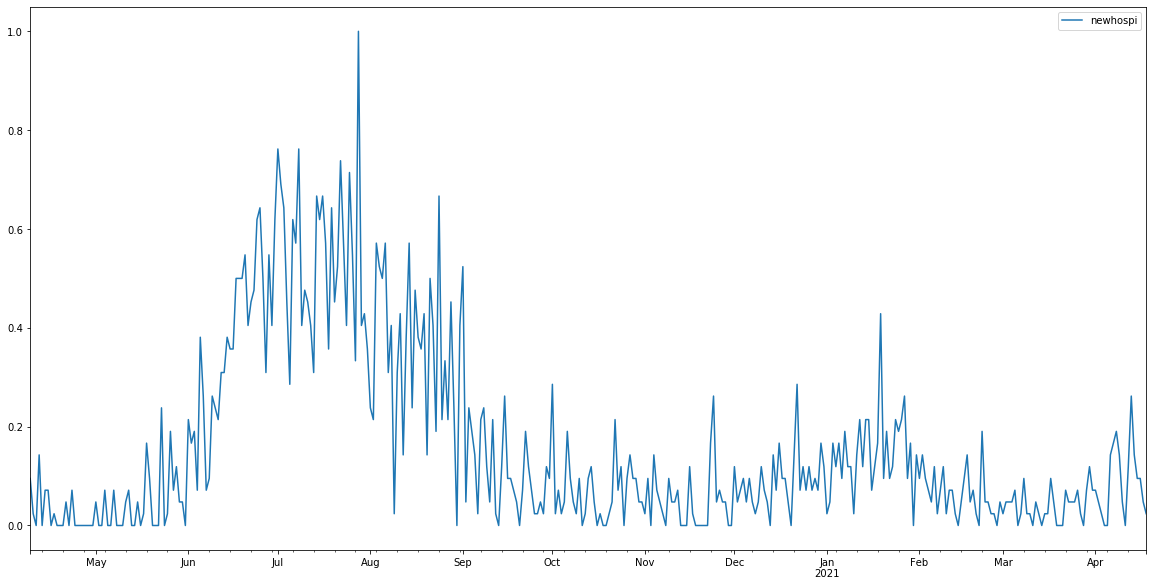

In [6]:
data = dffg[["numero","date",'newhospi']]
data = data[data["numero"]==973].drop_duplicates()
print(data)
data["newhospi"]=max_normalize(data["newhospi"])
data = data[["date","newhospi"]]
idx = pd.date_range(data["date"].min(), data["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

#### The features: 22 variables from which we will predict our target

In [7]:
feat = df[featurespm25]
print(feat.columns)
print(len(feat.columns))

Index(['idx', 'pm25', 'pm257davg', 'normpm25', 'hospiprevday',
       'covidpostestprevday', 'CovidPosTest',
       'prevdaytotalcovidcasescumulated',
       'all_day_bing_tiles_visited_relative_change',
       'all_day_ratio_single_tile_users', 'vac1nb', 'vac2nb',
       'Insuffisance respiratoire chronique grave (ALD14)',
       'Insuffisance cardiaque grave, troubles du rythme graves, cardiopathies valvulaires graves, cardiopathies congénitales graves (ALD5)',
       'Smokers', 'minority', 'Nb_susp_501Y_V1', 'Nb_susp_501Y_V2_3',
       '1MMaxpm25', 'pm251Mavg', 'pauvrete', 'rsa', 'ouvriers'],
      dtype='object')
23


#### The Target: New hospitalizations due to severe COVID19 cases

The daily number of new hospitalizations due to severe COVID19 cases for every French departement is what we will predict.

### New hospitalizations means over all departements as a function of 7davg pollutants concentrations differencials

Text(0, 0.5, 'newhospimean')

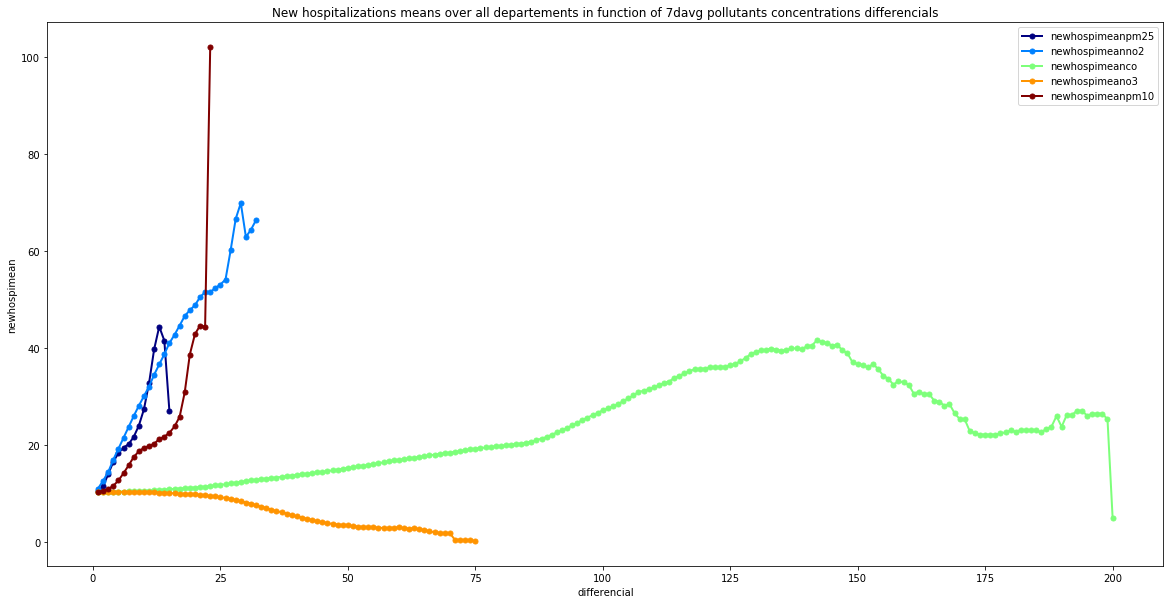

In [8]:
#differencial = 31.857825
newhospimeanlist = []
for i in range(1,400):
    differencial = i
    #print(dataforanalysis["newhospi"].mean())
    #print(dataforanalysis[dataforanalysis["pm257davg"]>dataforanalysis["pm257davg"].min()+differencial]["newhospi"].mean())
    newhospimeanlist.append((i,dataforanalysis[dataforanalysis["pm257davg"]>dataforanalysis["pm257davg"].min()+differencial]["newhospi"].mean(),\
                            dataforanalysis[dataforanalysis["no27davg"]>dataforanalysis["no27davg"].min()+differencial]["newhospi"].mean(),
                            dataforanalysis[dataforanalysis["co7davg"]>dataforanalysis["co7davg"].min()+differencial]["newhospi"].mean(),
                            dataforanalysis[(dataforanalysis["o37davg"]>dataforanalysis["o37davg"].min()+differencial)]["newhospi"].mean(),
                            dataforanalysis[(dataforanalysis["pm107davg"]>dataforanalysis["pm107davg"].min()+differencial)]["newhospi"].mean()))
    #print((dataforanalysis[dataforanalysis["pm257davg"]>dataforanalysis["pm257davg"].min()+differencial]["newhospi"].mean()-dataforanalysis["newhospi"].mean())/differencial)
newhospimeandf = pd.DataFrame(newhospimeanlist)
newhospimeandf.columns=["pm257davgdifferencial","newhospimeanpm25","newhospimeanno2","newhospimeanco","newhospimeano3","newhospimeanpm10"]
idx = newhospimeandf["pm257davgdifferencial"].tolist()
newhospimeandf.drop(columns = ["pm257davgdifferencial"],inplace = True)
newhospimeandf.index = idx
ax = newhospimeandf.plot.line(lw=2, colormap='jet', marker='.', markersize=10, title='New hospitalizations means over all departements in function of 7davg pollutants concentrations differencials', figsize = (20,10))
ax.set_xlabel("differencial")
ax.set_ylabel("newhospimean")

### New hospitalizations means over all departements as a function of 1Mavg - Pollutants concentrations differencials

Text(0, 0.5, 'newhospimean')

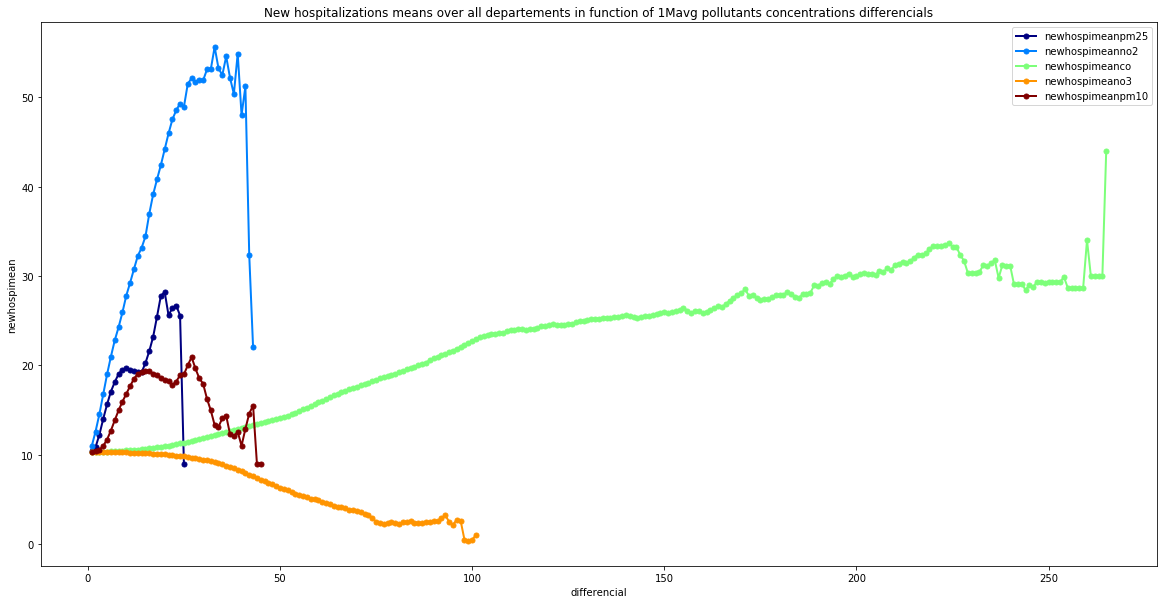

In [9]:
#differencial = 31.857825
newhospimeanlist = []
for i in range(1,400):
    differencial = i
    #print(dataforanalysis["newhospi"].mean())
    #print(dataforanalysis[dataforanalysis["pm251Mavg"]>dataforanalysis["pm251Mavg"].min()+differencial]["newhospi"].mean())
    newhospimeanlist.append((i,dataforanalysis[dataforanalysis["pm251Mavg"]>dataforanalysis["pm251Mavg"].min()+differencial]["newhospi"].mean(),\
                            dataforanalysis[dataforanalysis["no21Mavg"]>dataforanalysis["no21Mavg"].min()+differencial]["newhospi"].mean(),
                            dataforanalysis[dataforanalysis["co1Mavg"]>dataforanalysis["co1Mavg"].min()+differencial]["newhospi"].mean(),
                            dataforanalysis[(dataforanalysis["o31Mavg"]>dataforanalysis["o31Mavg"].min()+differencial)]["newhospi"].mean(),
                            dataforanalysis[(dataforanalysis["pm101Mavg"]>dataforanalysis["pm101Mavg"].min()+differencial)]["newhospi"].mean()))
    #print((dataforanalysis[dataforanalysis["pm251Mavg"]>dataforanalysis["pm251Mavg"].min()+differencial]["newhospi"].mean()-dataforanalysis["newhospi"].mean())/differencial)
newhospimeandf = pd.DataFrame(newhospimeanlist)
newhospimeandf.columns=["pm251Mavgdifferencial","newhospimeanpm25","newhospimeanno2","newhospimeanco","newhospimeano3","newhospimeanpm10"]
idx = newhospimeandf["pm251Mavgdifferencial"].tolist()
newhospimeandf.drop(columns = ["pm251Mavgdifferencial"],inplace = True)
newhospimeandf.index = idx
ax = newhospimeandf.plot.line(lw=2, colormap='jet', marker='.', markersize=10, title='New hospitalizations means over all departements in function of 1Mavg pollutants concentrations differencials', figsize = (20,10))
ax.set_xlabel("differencial")
ax.set_ylabel("newhospimean")

### New hospitalizations means over all departements as a function of 1MMax Pollutants concentrations differencials

Text(0, 0.5, 'newhospimean')

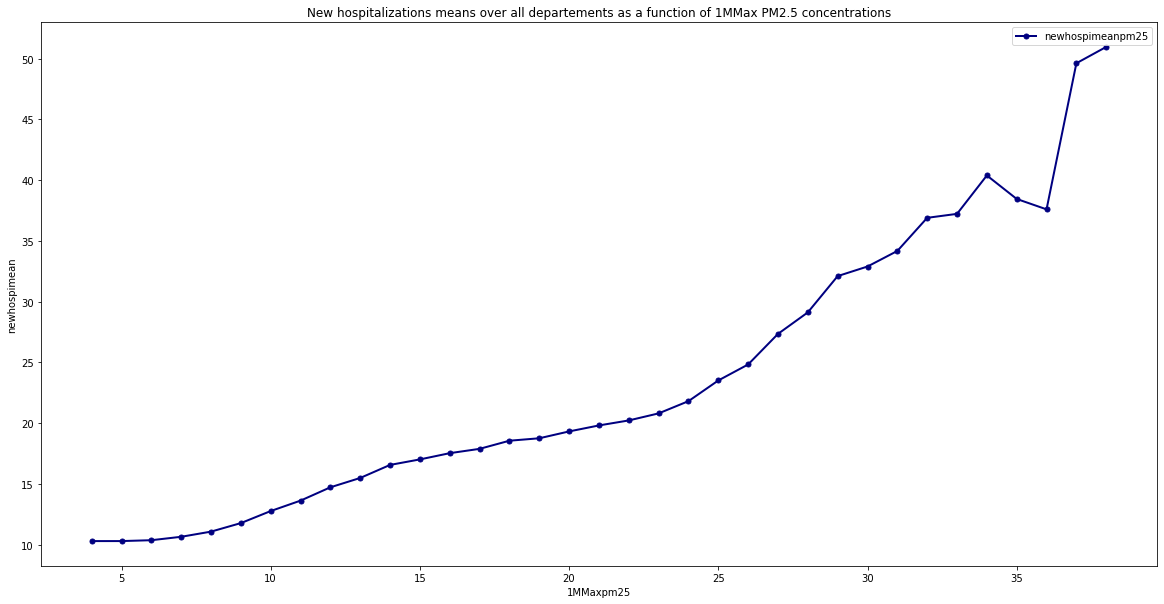

In [10]:
#differencial = 31.857825
newhospimeanlist = []
for i in range(int(dataforanalysis["1MMaxpm25"].min()),int(dataforanalysis["1MMaxpm25"].max()),1):
    #print(dataforanalysis["newhospi"].mean())
    #print(dataforanalysis[dataforanalysis["1MMaxpm25"]>i]["newhospi"].mean())
    newhospimeanlist.append((i,dataforanalysis[dataforanalysis["1MMaxpm25"]>i]["newhospi"].mean()))
    #print((dataforanalysis[dataforanalysis["1MMaxpm25"]>i]["newhospi"].mean()-dataforanalysis["newhospi"].mean())/differencial)
newhospimeandf = pd.DataFrame(newhospimeanlist)
newhospimeandf.columns=["1MMaxpm25","newhospimeanpm25"]
idx = newhospimeandf["1MMaxpm25"].tolist()
newhospimeandf.drop(columns = ["1MMaxpm25"],inplace = True)
newhospimeandf.index = idx
ax = newhospimeandf.plot.line(lw=2, colormap='jet', marker='.', markersize=10, title='New hospitalizations means over all departements as a function of 1MMax PM2.5 concentrations', figsize = (20,10))
ax.set_xlabel("1MMaxpm25")
ax.set_ylabel("newhospimean")


Text(0, 0.5, 'newhospimean')

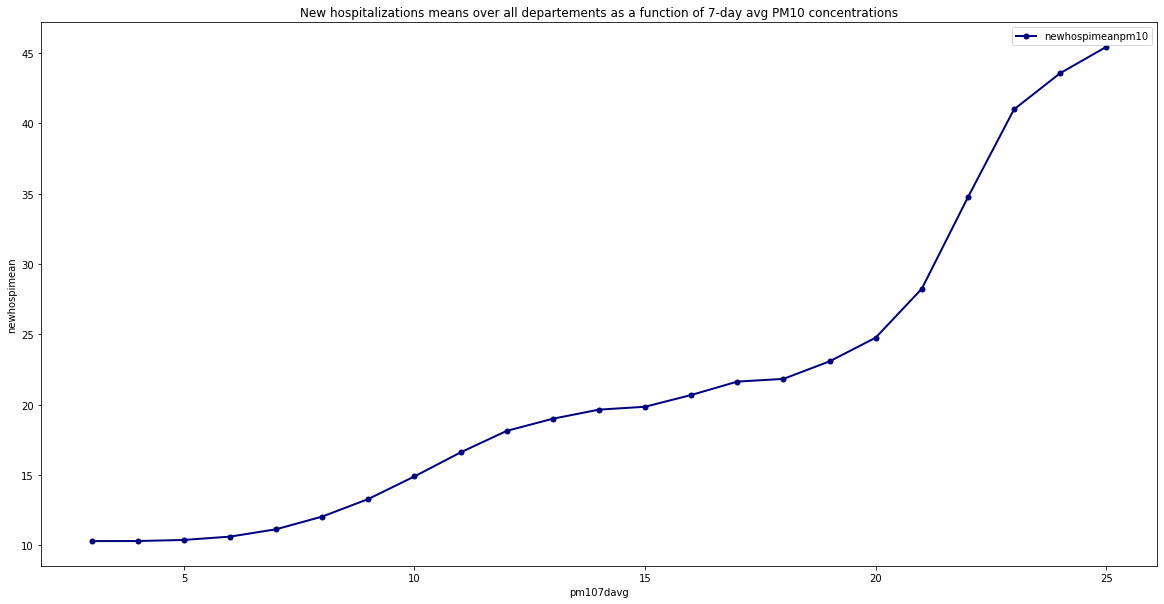

In [11]:
#differencial = 31.857825
newhospimeanlist = []
for i in range(int(dataforanalysis["pm107davg"].min()),int(dataforanalysis["pm107davg"].max()),1):
    #print(dataforanalysis["newhospi"].mean())
    #print(dataforanalysis[dataforanalysis["1MMaxpm25"]>i]["newhospi"].mean())
    newhospimeanlist.append((i,dataforanalysis[dataforanalysis["pm107davg"]>i]["newhospi"].mean()))
    #print((dataforanalysis[dataforanalysis["1MMaxpm25"]>i]["newhospi"].mean()-dataforanalysis["newhospi"].mean())/differencial)
newhospimeandf = pd.DataFrame(newhospimeanlist)
newhospimeandf.columns=["pm107davg","newhospimeanpm10"]
idx = newhospimeandf["pm107davg"].tolist()
newhospimeandf.drop(columns = ["pm107davg"],inplace = True)
newhospimeandf.index = idx
ax = newhospimeandf.plot.line(lw=2, colormap='jet', marker='.', markersize=10, title='New hospitalizations means over all departements as a function of 7-day avg PM10 concentrations', figsize = (20,10))
ax.set_xlabel("pm107davg")
ax.set_ylabel("newhospimean")

Text(0, 0.5, 'newhospimean')

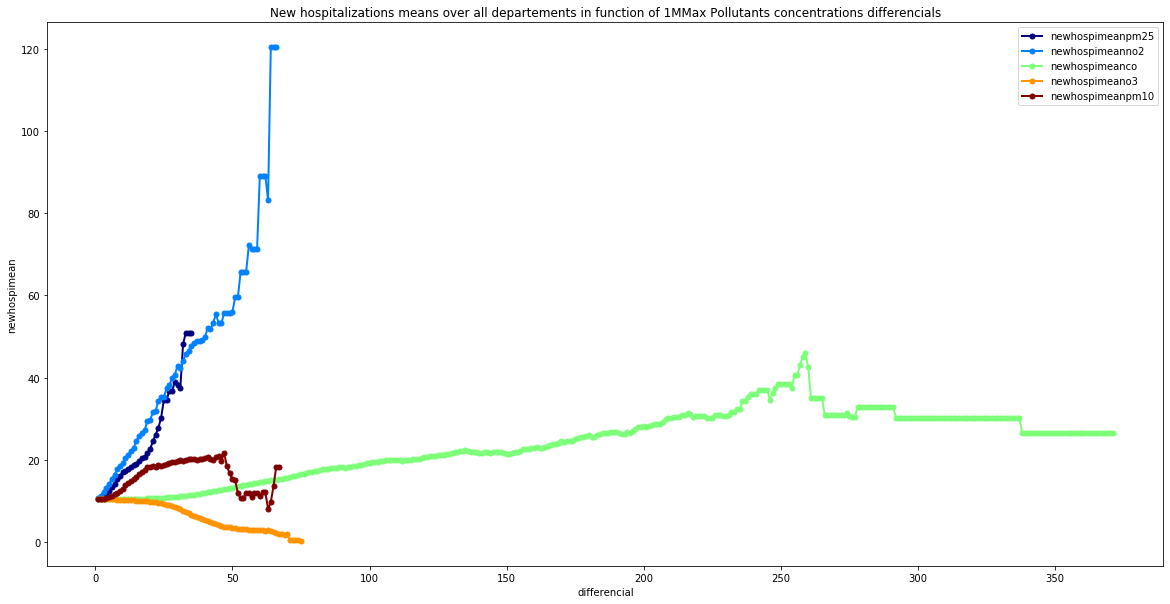

In [12]:
#differencial = 31.857825
newhospimeanlist = []
for i in range(1,400):
    differencial = i
    #print(dataforanalysis["newhospi"].mean())
    #print(dataforanalysis[dataforanalysis["1MMaxpm25"]>dataforanalysis["1MMaxpm25"].min()+differencial]["newhospi"].mean())
    newhospimeanlist.append((i,dataforanalysis[dataforanalysis["1MMaxpm25"]>dataforanalysis["1MMaxpm25"].min()+differencial]["newhospi"].mean(),\
                            dataforanalysis[dataforanalysis["1MMaxno2"]>dataforanalysis["1MMaxno2"].min()+differencial]["newhospi"].mean(),
                            dataforanalysis[dataforanalysis["1MMaxco"]>dataforanalysis["1MMaxco"].min()+differencial]["newhospi"].mean(),
                            dataforanalysis[(dataforanalysis["o37davg"]>dataforanalysis["o37davg"].min()+differencial)]["newhospi"].mean(),
                            dataforanalysis[(dataforanalysis["1MMaxpm10"]>dataforanalysis["1MMaxpm10"].min()+differencial)]["newhospi"].mean()))
    #print((dataforanalysis[dataforanalysis["1MMaxpm25"]>dataforanalysis["1MMaxpm25"].min()+differencial]["newhospi"].mean()-dataforanalysis["newhospi"].mean())/differencial)
newhospimeandf = pd.DataFrame(newhospimeanlist)
newhospimeandf.columns=["1MMaxpm25differencial","newhospimeanpm25","newhospimeanno2","newhospimeanco","newhospimeano3","newhospimeanpm10"]
idx = newhospimeandf["1MMaxpm25differencial"].tolist()
newhospimeandf.drop(columns = ["1MMaxpm25differencial"],inplace = True)
newhospimeandf.index = idx
ax = newhospimeandf.plot.line(lw=2, colormap='jet', marker='.', markersize=10, title='New hospitalizations means over all departements in function of 1MMax Pollutants concentrations differencials', figsize = (20,10))
ax.set_xlabel("differencial")
ax.set_ylabel("newhospimean")


### Ozone (O3) and the number of severe COVID19 cases leading to hospitalization

#### Departement 75: Paris region Ile de France

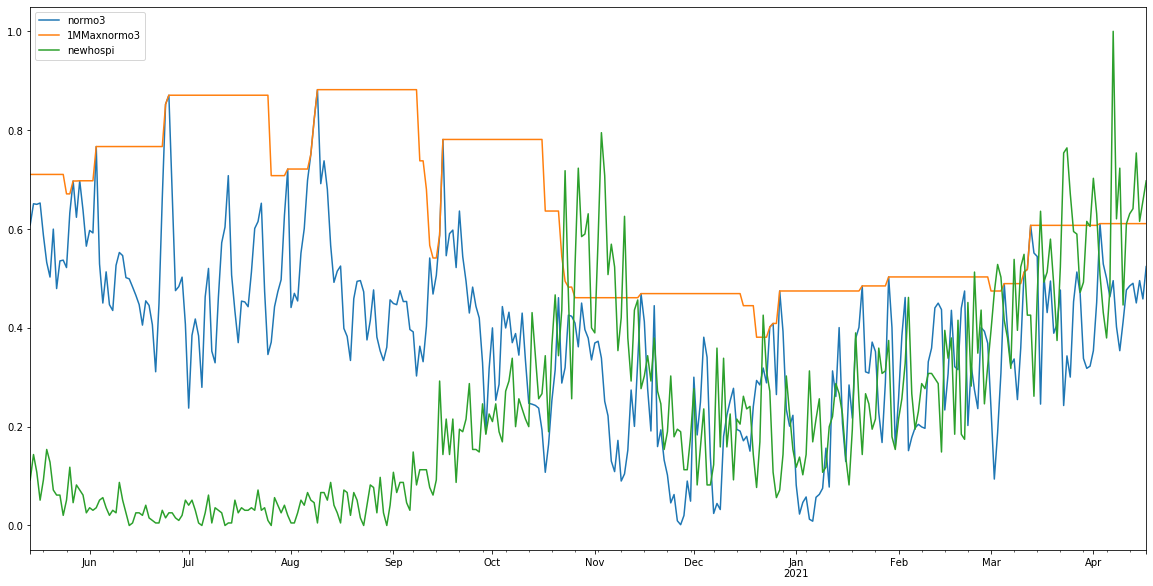

In [13]:
data = df[["numero","date","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normo3","1MMaxnormo3",\
           'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

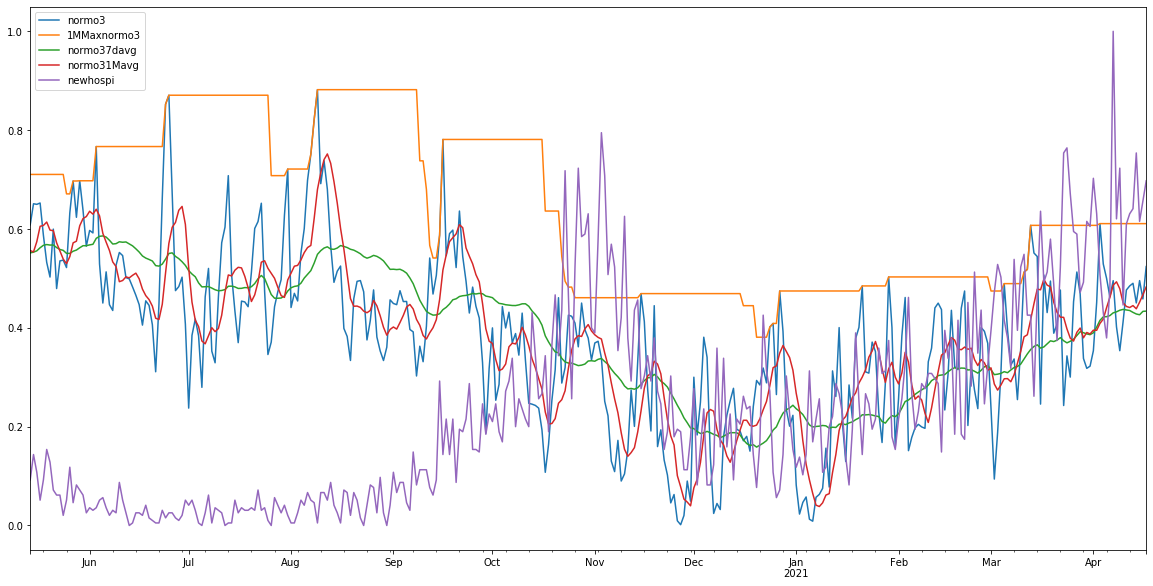

In [14]:
data = df[["numero","date","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normo3","1MMaxnormo3","normo37davg",\
            "normo31Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

#### Departement 83: Var region PACA

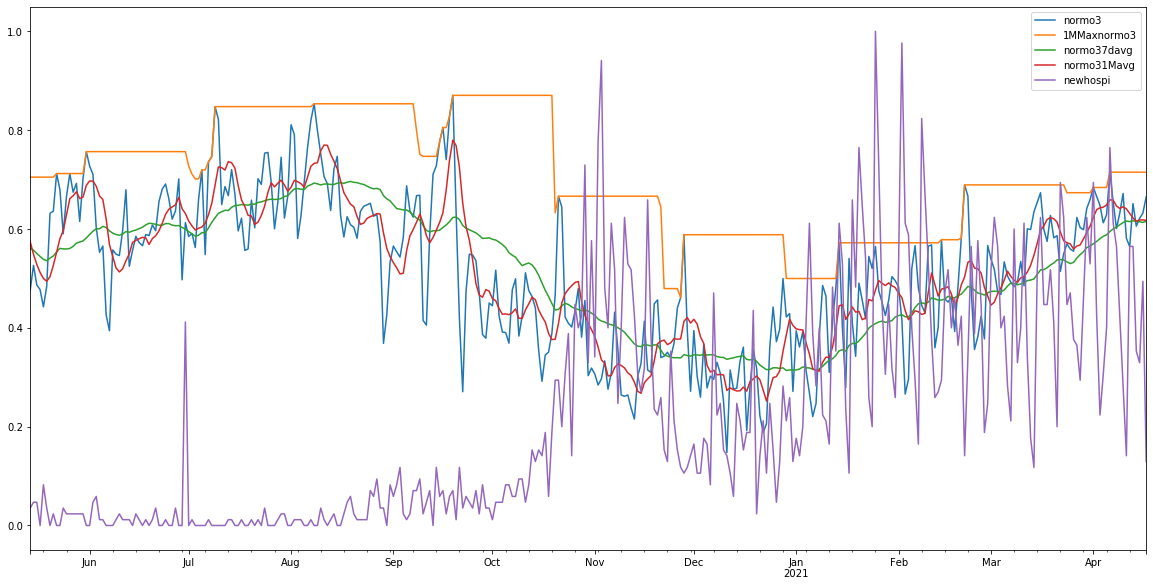

In [15]:
data = df[["numero","date","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==83][["normo3","1MMaxnormo3","normo37davg",\
            "normo31Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

### Nitrogen dioxide (NO2) and the number of severe COVID19 cases leading to hospitalization

#### Departement 75: Paris region Ile de France

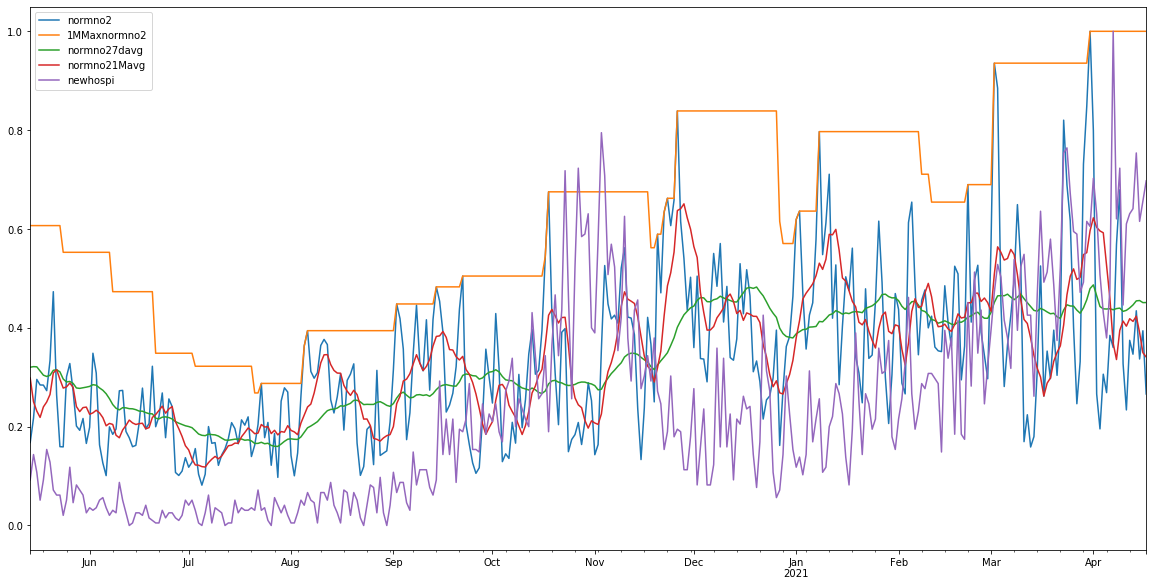

In [16]:
data = df[["numero","date","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normno2","1MMaxnormno2","normno27davg",\
            "normno21Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

#### Departement 83: Var region PACA


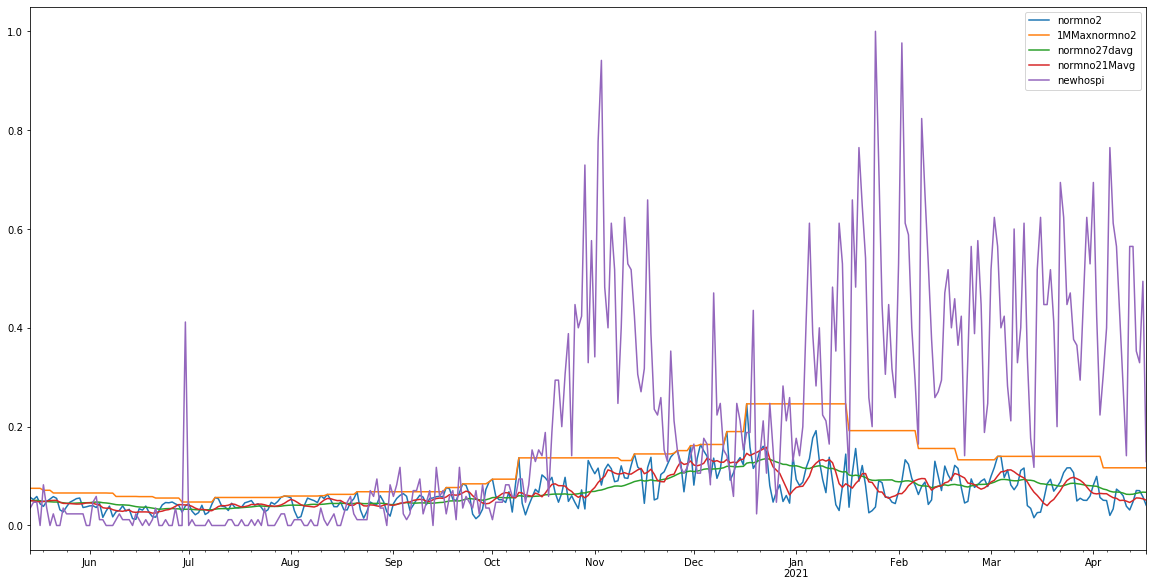

In [17]:
data = df[["numero","date","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==83][["normno2","1MMaxnormno2","normno27davg",\
            "normno21Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

### PM2.5 and the number of severe COVID19 cases leading to hospitalization

#### Departement 75: Paris region Ile de France

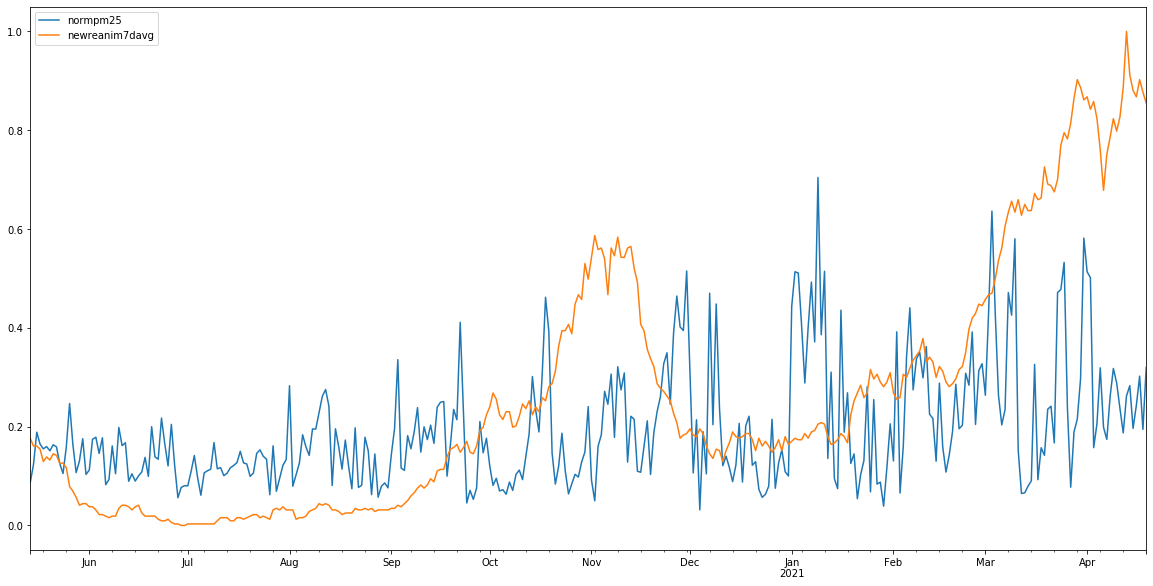

In [9]:
data = df[['1MMaxnormpm25',"numero","date","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newreanim',"CovidPosTest","newhospi","newhospi7davg","newreanim7davg"]]
data = data[data["numero"]==75][["normpm25","newreanim7davg"]]
#data["newhospi"]=max_normalize(data["newhospi"])
#data["3davgnewhospi"]=max_normalize(data["3davgnewhospi"])
data["newreanim7davg"]=max_normalize(data["newreanim7davg"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

#### Departement 93: Seine Saint-Denis région Île-de-France

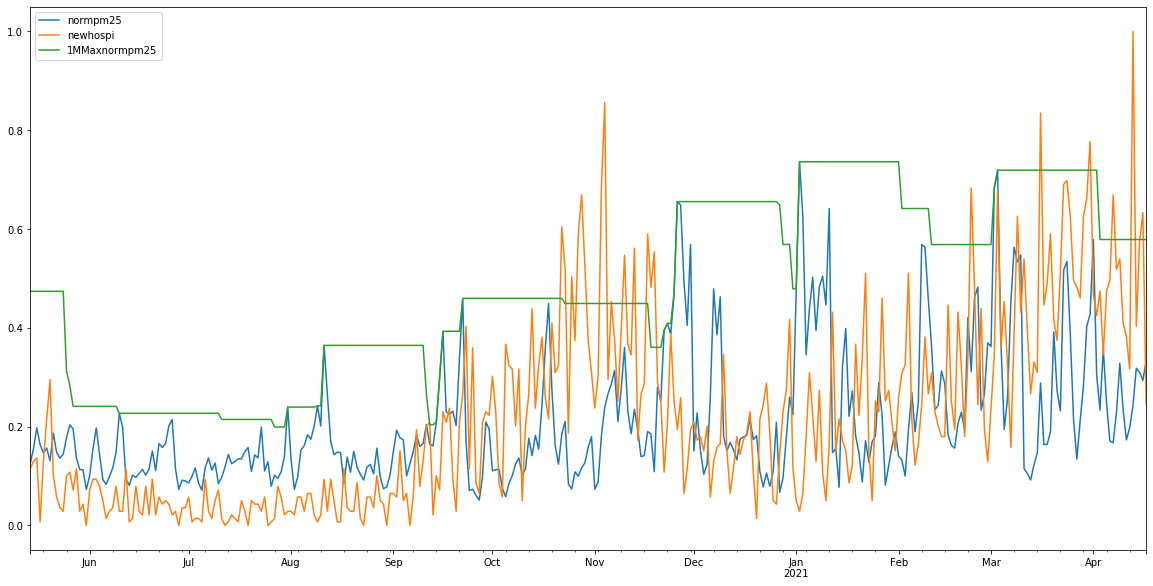

In [20]:
data = df[['1MMaxnormpm25',"numero","date","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newreanim',"CovidPosTest","newhospi"]]
data = data[data["numero"]==93][["normpm25","newhospi", "1MMaxnormpm25"]]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

In [24]:
data = df[['1MMaxnormpm25',"numero","date","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newreanim',"CovidPosTest","newhospi","newreanim","newhospi7davg","newreanim7davg","newhospi3davg","newreanim3davg"]]
data = data[data["numero"]==93][["normpm25","newhospi", "1MMaxnormpm25","newhospi7davg","newreanim7davg","newhospi3davg","newreanim3davg"]]
data["newhospi"]=max_normalize(data["newhospi"])
data["newhospi7davg"]=max_normalize(data["newhospi7davg"])
data["newhospi3davg"]=max_normalize(data["newhospi3davg"])
data["newreanim"]=max_normalize(data["newreanim"])
data["newreanim7davg"]=max_normalize(data["newreanim7davg"])
data["newreanim3davg"]=max_normalize(data["newreanim3davg"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))


KeyError: 'newreanim'

In [ ]:
data = df[['1MMaxnormpm25',"numero","date","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newreanim']]
data = data[data["numero"]==75][["normpm25","1MMaxnormpm25","normpm257davg",\
            "normpm251Mavg",'newreanim']]
data["newreanim"]=max_normalize(data["newreanim"])
idx = pd.date_range(df["date"].min(),df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

In [ ]:
data = df[['1MMaxnormpm25',"numero","date","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normpm25","1MMaxnormpm25","normpm257davg",\
            "normpm251Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))


In [ ]:
data = df[['1MMaxnormpm25',"numero","date","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newreanim']]
data = data[data["numero"]==75][["normpm25","1MMaxnormpm25","normpm257davg",\
            "normpm251Mavg",'newreanim']]
data["newreanim"]=max_normalize(data["newreanim"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

In [ ]:
data = df[['1MMaxnormpm25',"numero","date","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normpm10","normpm107davg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(),df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

In [ ]:
data = df[['1MMaxnormpm25',"numero","date","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normpm10","normpm107davg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(),df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

In [ ]:
data = df[['1MMaxnormpm25',"numero","date","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normpm25","1MMaxnormpm25",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

In [ ]:
data = df[['1MMaxnormpm25',"numero","date","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newreanim']]
data = data[data["numero"]==75][["normpm25",'newreanim']]
data["newreanim"]=max_normalize(data["newreanim"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

In [ ]:
data = df[['1MMaxnormpm25',"numero","date","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normpm25","1MMaxnormpm25","normpm257davg",\
            "normpm251Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(),df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

#### Departement 83: Var region PACA

In [ ]:
data = df[['1MMaxnormpm25',"numero","date","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==83][["normpm25","1MMaxnormpm25","normpm257davg",\
            "normpm251Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

In [ ]:
data = df[['1MMaxnormpm25',"numero","date","1MMaxnormno2","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==21][["normpm25","1MMaxnormpm25","normpm257davg",\
            "normpm251Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

#### Departement21: Côte d'Or

### CO and the number of severe COVID19 cases leading to hospitalization

#### Departement 75: Paris region Ile de France

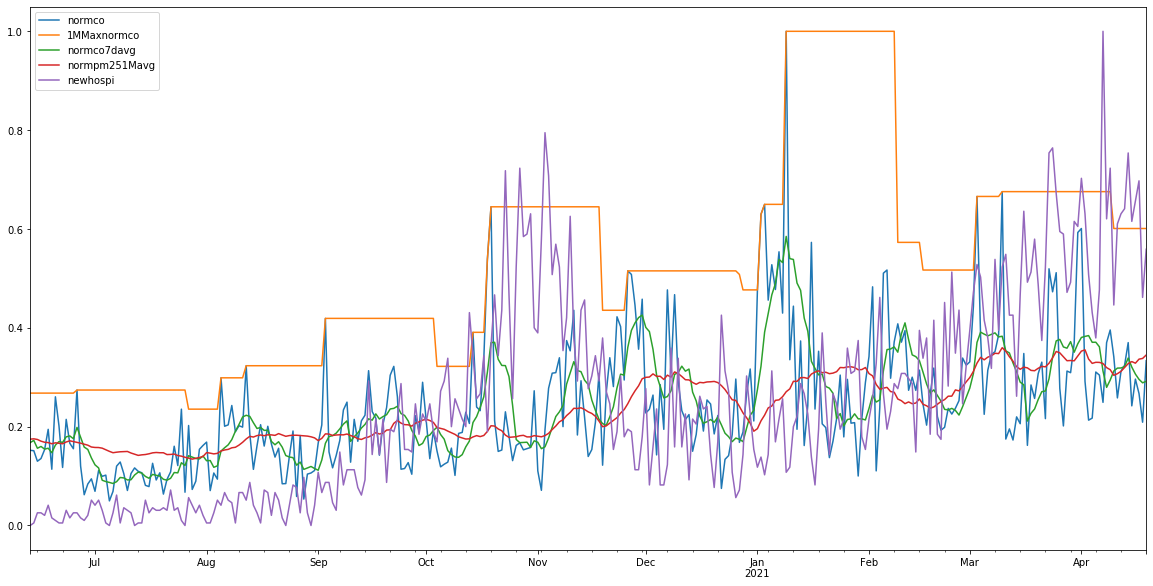

In [2]:
data = df[['1MMaxnormpm25',"numero","date","1MMaxnormco","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normco","1MMaxnormco","normco7davg",\
            "normpm251Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

### SO2 and the number of severe COVID19 cases leading to hospitalization

In [9]:
data = df[['1MMaxnormpm25',"numero","date","1MMaxnormco","1MMaxnormso2","normso21Mavg","normso27davg","normpm25","normno2","normso2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normco","1MMaxnormso2","normso27davg",\
            "normso21Mavg",'newhospi']]
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

KeyError: "['normso21Mavg'] not in index"

### The most polluted departements of France

#### The Ozone O3 Pollutant

In [ ]:
datalist =[]
df2 = df.copy()
maximum_o3_pollution_level = df2[(df2["1MMaxo3"]==df2["1MMaxo3"].max())]
datalist.append((maximum_o3_pollution_level["nom"].unique()[0],\
                 maximum_o3_pollution_level["numero"].unique()[0],
                 maximum_o3_pollution_level["date"].min(),\
                 maximum_o3_pollution_level["1MMaxo3"].unique()[0],\
                 df2[df2["numero"]== maximum_o3_pollution_level["numero"].unique()[0]]['totalcovidcasescumulated'].max(),\
                 maximum_o3_pollution_level["idx"].unique()[0]))
alreadyseen = maximum_o3_pollution_level["nom"].unique()[0]
print(maximum_o3_pollution_level["numero"].unique())
counter = 1



while (counter !=95):
    counter += 1
    df2 = df2[df2["nom"]  != alreadyseen]
    maximum_o3_pollution_level = df2[(df2["1MMaxo3"]==df2["1MMaxo3"].max())]
    datalist.append((maximum_o3_pollution_level["nom"].unique()[0],\
                     maximum_o3_pollution_level["numero"].unique()[0],
                     maximum_o3_pollution_level["date"].min(),\
                     maximum_o3_pollution_level["1MMaxo3"].unique()[0],\
                     df2[df2["nom"]==maximum_o3_pollution_level["nom"].unique()[0]]['totalcovidcasescumulated'].max(),
                     maximum_o3_pollution_level["idx"].unique()[0]))
                     
    
    alreadyseen = maximum_o3_pollution_level["nom"].unique()[0]

dfexport = pd.DataFrame(datalist)
dfexport.columns=["Département","Numéro","Date of pollution peak","1MMaxo3",'totalcovidcasescumulated',"Population Index"]
print(dfexport)
dfexport.to_csv("../research/Pollution study by departement o3 1Y Max 1M-TM.csv", index = False)


#### The PM2.5 Pollutant

In [ ]:

datalist =[]
df2 = df.copy()
maximum_pm25_pollution_level = df2[(df2["1MMaxpm25"]==df2["1MMaxpm25"].max())]
datalist.append((maximum_pm25_pollution_level["nom"].unique()[0],\
                 maximum_pm25_pollution_level["numero"].unique()[0],
                 maximum_pm25_pollution_level["date"].min(),\
                 maximum_pm25_pollution_level["1MMaxpm25"].unique()[0],\
                 df2[df2["numero"]== maximum_pm25_pollution_level["numero"].unique()[0]]['totalcovidcasescumulated'].max(),\
                 maximum_pm25_pollution_level["idx"].unique()[0]))
alreadyseen = maximum_pm25_pollution_level["nom"].unique()[0]
print(maximum_pm25_pollution_level["numero"].unique())
counter = 1



while (counter !=95):
    counter += 1
    df2 = df2[df2["nom"]  != alreadyseen]
    maximum_pm25_pollution_level = df2[(df2["1MMaxpm25"]==df2["1MMaxpm25"].max())]
    datalist.append((maximum_pm25_pollution_level["nom"].unique()[0],\
                     maximum_pm25_pollution_level["numero"].unique()[0],
                     maximum_pm25_pollution_level["date"].min(),\
                     maximum_pm25_pollution_level["1MMaxpm25"].unique()[0],\
                     df2[df2["nom"]==maximum_pm25_pollution_level["nom"].unique()[0]]['totalcovidcasescumulated'].max(),
                     maximum_pm25_pollution_level["idx"].unique()[0]))
                     
    
    alreadyseen = maximum_pm25_pollution_level["nom"].unique()[0]

dfexport = pd.DataFrame(datalist)
dfexport.columns=["Département","Numéro","Date of pollution peak","1MMaxpm25",'totalcovidcasescumulated',"Population Index"]
print(dfexport)
dfexport.to_csv("../research/Pollution study by departement pm25 1Y Max 1M-TM.csv", index = False)


#### The NO2 Pollutant

In [ ]:
datalist =[]
df2 = df.copy()
maximum_no2_pollution_level = df2[(df2["1MMaxno2"]==df2["1MMaxno2"].max())]
datalist.append((maximum_no2_pollution_level["nom"].unique()[0],\
                 maximum_no2_pollution_level["numero"].unique()[0],
                 maximum_no2_pollution_level["date"].min(),\
                 maximum_no2_pollution_level["1MMaxno2"].unique()[0],\
                 df2[df2["numero"]== maximum_no2_pollution_level["numero"].unique()[0]]['totalcovidcasescumulated'].max(),\
                 maximum_no2_pollution_level["idx"].unique()[0]))
alreadyseen = maximum_no2_pollution_level["nom"].unique()[0]
print(maximum_no2_pollution_level["numero"].unique())
counter = 1



while (counter !=95):
    counter += 1
    df2 = df2[df2["nom"]  != alreadyseen]
    maximum_no2_pollution_level = df2[(df2["1MMaxno2"]==df2["1MMaxno2"].max())]
    datalist.append((maximum_no2_pollution_level["nom"].unique()[0],\
                     maximum_no2_pollution_level["numero"].unique()[0],
                     maximum_no2_pollution_level["date"].min(),\
                     maximum_no2_pollution_level["1MMaxno2"].unique()[0],\
                     df2[df2["nom"]==maximum_no2_pollution_level["nom"].unique()[0]]['totalcovidcasescumulated'].max(),
                     maximum_no2_pollution_level["idx"].unique()[0]))
                     
    
    alreadyseen = maximum_no2_pollution_level["nom"].unique()[0]

dfexport = pd.DataFrame(datalist)
dfexport.columns=["Département","Numéro","Date of pollution peak","1MMaxno2",'totalcovidcasescumulated',"Population Index"]
print(dfexport)
dfexport.to_csv("../research/Pollution study by departement no2 1Y Max 1M-TM.csv", index = False)


#### The CO Pollutant

In [ ]:
datalist =[]
df2 = df.copy()
maximum_co_pollution_level = df2[(df2["1MMaxco"]==df2["1MMaxco"].max())]
datalist.append((maximum_co_pollution_level["nom"].unique()[0],\
                 maximum_co_pollution_level["numero"].unique()[0],
                 maximum_co_pollution_level["date"].min(),\
                 maximum_co_pollution_level["1MMaxco"].unique()[0],\
                 df2[df2["numero"]== maximum_co_pollution_level["numero"].unique()[0]]['totalcovidcasescumulated'].max(),\
                 maximum_co_pollution_level["idx"].unique()[0]))
alreadyseen = maximum_co_pollution_level["nom"].unique()[0]
print(maximum_co_pollution_level["numero"].unique())
counter = 1



while (counter !=95):
    counter += 1
    df2 = df2[df2["nom"]  != alreadyseen]
    maximum_co_pollution_level = df2[(df2["1MMaxco"]==df2["1MMaxco"].max())]
    datalist.append((maximum_co_pollution_level["nom"].unique()[0],\
                     maximum_co_pollution_level["numero"].unique()[0],
                     maximum_co_pollution_level["date"].min(),\
                     maximum_co_pollution_level["1MMaxco"].unique()[0],\
                     df2[df2["nom"]==maximum_co_pollution_level["nom"].unique()[0]]['totalcovidcasescumulated'].max(),
                     maximum_co_pollution_level["idx"].unique()[0]))
                     
    
    alreadyseen = maximum_co_pollution_level["nom"].unique()[0]

dfexport = pd.DataFrame(datalist)
dfexport.columns=["Département","Numéro","Date of pollution peak","1MMaxco",'totalcovidcasescumulated',"Population Index"]
print(dfexport)
dfexport.to_csv("../research/Pollution study by departement co 1Y Max 1M-TM.csv", index = False)



#### The PM10 Pollutant

In [ ]:
datalist =[]
df2 = df.copy()
maximum_pm10_pollution_level = df2[(df2["1MMaxpm10"]==df2["1MMaxpm10"].max())]
datalist.append((maximum_pm10_pollution_level["nom"].unique()[0],\
                 maximum_pm10_pollution_level["numero"].unique()[0],
                 maximum_pm10_pollution_level["date"].min(),\
                 maximum_pm10_pollution_level["1MMaxpm10"].unique()[0],\
                 df2[df2["numero"]== maximum_pm10_pollution_level["numero"].unique()[0]]['totalcovidcasescumulated'].max(),\
                 maximum_pm10_pollution_level["idx"].unique()[0]))
alreadyseen = maximum_pm10_pollution_level["nom"].unique()[0]
print(maximum_pm10_pollution_level["numero"].unique())
pm10unter = 1



while (pm10unter !=95):
    pm10unter += 1
    df2 = df2[df2["nom"]  != alreadyseen]
    maximum_pm10_pollution_level = df2[(df2["1MMaxpm10"]==df2["1MMaxpm10"].max())]
    datalist.append((maximum_pm10_pollution_level["nom"].unique()[0],\
                     maximum_pm10_pollution_level["numero"].unique()[0],
                     maximum_pm10_pollution_level["date"].min(),\
                     maximum_pm10_pollution_level["1MMaxpm10"].unique()[0],\
                     df2[df2["nom"]==maximum_pm10_pollution_level["nom"].unique()[0]]['totalcovidcasescumulated'].max(),
                     maximum_pm10_pollution_level["idx"].unique()[0]))
                     
    
    alreadyseen = maximum_pm10_pollution_level["nom"].unique()[0]

dfexport = pd.DataFrame(datalist)
dfexport.columns=["Département","Numéro","Date of pollution peak","1MMaxpm10",'totalcovidcasescumulated',"Population Index"]
print(dfexport)
dfexport.to_csv("../research/Pollution study by departement pm10 1Y Max 1M-TM.csv", index = False)



### The facebook mobility index

#### The facebook mobility index VS Ozone O3

In [ ]:
data = df[['all_day_ratio_single_tile_users','1MMaxnormpm25',"numero","date","1MMaxnormco","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normo3",'all_day_ratio_single_tile_users','newhospi']]
data['all_day_ratio_single_tile_users']=max_normalize(data['all_day_ratio_single_tile_users'])
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

#### The facebook mobility index VS Carbon Monoxyde CO

In [ ]:
data = df[['all_day_ratio_single_tile_users','1MMaxnormpm25',"numero","date","1MMaxnormco","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normco",'all_day_ratio_single_tile_users','newhospi']]
data['all_day_ratio_single_tile_users']=max_normalize(data['all_day_ratio_single_tile_users'])
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

#### The facebook mobility index VS Nitrogen Dioxide NO2

In [ ]:
data = df[['all_day_ratio_single_tile_users','1MMaxnormpm25',"numero","date","1MMaxnormco","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normno2",'all_day_ratio_single_tile_users','newhospi']]
data['all_day_ratio_single_tile_users']=max_normalize(data['all_day_ratio_single_tile_users'])
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

#### The facebook mobility index VS PM2.5

In [ ]:
data = df[['all_day_ratio_single_tile_users','1MMaxnormpm25',"numero","date","1MMaxnormco","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normpm25",'all_day_ratio_single_tile_users','newhospi']]
data['all_day_ratio_single_tile_users']=max_normalize(data['all_day_ratio_single_tile_users'])
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(),df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

In [ ]:
data = df[['all_day_bing_tiles_visited_relative_change','1MMaxnormpm25',"numero","date","1MMaxnormco","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normpm25",'all_day_bing_tiles_visited_relative_change','newhospi']]
data['all_day_bing_tiles_visited_relative_change']=max_normalize(data['all_day_bing_tiles_visited_relative_change'])
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

#### The facebook mobility index VS PM10

In [ ]:
data = df[['all_day_ratio_single_tile_users','1MMaxnormpm25',"numero","date","1MMaxnormco","normpm25","normno2","normo3","normpm10","normco","1MMaxnormo3","normpm257davg","normno27davg","normo37davg","normpm107davg","normco7davg",\
            "normpm251Mavg","normno21Mavg","normo31Mavg","normpm101Mavg","normco1Mavg",'newhospi']]
data = data[data["numero"]==75][["normpm10",'all_day_ratio_single_tile_users','newhospi']]
data['all_day_ratio_single_tile_users']=max_normalize(data['all_day_ratio_single_tile_users'])
data["newhospi"]=max_normalize(data["newhospi"])
idx = pd.date_range(df["date"].min(), df["date"].max()).tolist()
data.index = idx
data.plot.line(figsize = (20,10))

## Training the model - Gradient Boosting for regression

Gradient Boosting for regression.

GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.

Stack of estimators with a final regressor.

Stacked generalization consists in stacking the output of individual estimator and use a regressor to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

Note that estimators_ are fitted on the full X while final_estimator_ is trained using cross-validated predictions of the base estimators using cross_val_predict.

### Hold-out and Cross Validation (MSE/MAE)

In [ ]:
featurespm25 = ['idx', \
                'pm25','pm257davg','pm251Mavg','1MMaxpm25',\
                'pm10','pm107davg','pm101Mavg','1MMaxpm10',\
                'no2','no27davg','no21Mavg','1MMaxno2',\
                'o3','o37davg','o31Mavg','1MMaxo3',\
                'co','co7davg','co1Mavg','1MMaxco',\
        'hospiprevday','covidpostestprevday',\
               # 'prevdaytotalcovidcasescumulated',\
            'all_day_bing_tiles_visited_relative_change','all_day_ratio_single_tile_users','vac1nb', 'vac2nb',\
                 'Insuffisance respiratoire chronique grave (ALD14)', \
                     'Insuffisance cardiaque grave, troubles du rythme graves, cardiopathies valvulaires graves, cardiopathies congénitales graves (ALD5)',\
                         'Smokers',\
                         "minority",\
                             "Nb_susp_501Y_V1","Nb_susp_501Y_V2_3",\
                                    "pauvrete","rsa","ouvriers"\
                            ]

print(featurespm25)
X2=df[featurespm25]


y= df['newhospi']

# Hold-out
#X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.33)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.33)
print("\n")

# print(" Scikit Learn ExtratreesRegressor")
# ETregr = ExtraTreesRegressor()
# ETregr.fit(X_train2, y_train2)
# predET = ETregr.predict(X_test2).round(0)
# predETdf = pd.DataFrame(predET)
# predETdf.columns = ["prednewhospi"]
# featuresandtargetdf = X_test2.merge(y_test2, left_on = X_test2.index, right_on = y_test2.index)
# featuresandtargetdf["prednewhospi"]=predETdf["prednewhospi"].round(0)
# featuresandtargetdf.to_csv("../predictions/fr/new_hospi_predictions.csv", index = False)
# ETMSE = mse(y_test2, predET)
# ETMAE = mae(y_test2, predET)
# print("MSE")
# print(ETMSE)
# print("MAE")
# print(ETMAE)
# print("\n")


print("T-Pot exported current best pipeline")
# Average CV score on the training set was: -94.5319545151712
#exported_pipeline = ExtraTreesRegressor(bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=1, min_samples_split=4, n_estimators=100)
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=LinearSVR(C=10.0, dual=False, epsilon=0.1, loss="squared_epsilon_insensitive", tol=0.001)),
    MinMaxScaler(),
    GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, loss="huber", max_depth=8, max_features=1.0, min_samples_leaf=19, min_samples_split=11, n_estimators=100, subsample=0.9500000000000001)
)
exported_pipeline.fit(X_train2, y_train2)
predictions = exported_pipeline.predict(X_test2)
TPOTMSE = mse(y_test2, predictions)
TPOTMAE = mae (y_test2, predictions)
print("MSE:")
print(TPOTMSE)
print("MAE:")
print(TPOTMAE)
print("\n")

predictionstoexport = pd.DataFrame(exported_pipeline.predict(X2))
predictionstoexport.columns = ["newhospipred"]
print(predictionstoexport.shape)
print(df.shape)
df.reset_index(inplace = True)
predictionstoexport["date"]=df["date"]
predictionstoexport["depnum"]=df["numero"]
predictionstoexport["newhospi"]=df["newhospi"]
predictionstoexport.to_csv("../predictions/fr/predictions.csv", index = False)



In [ ]:
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=LinearSVR(C=10.0, dual=False, epsilon=0.1, loss="squared_epsilon_insensitive", tol=0.001)),
    MinMaxScaler(),
    GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, loss="huber", max_depth=8, max_features=1.0, min_samples_leaf=19, min_samples_split=11, n_estimators=100, subsample=0.9500000000000001)
)
scores = cross_validate(exported_pipeline, X2, y, cv=5,
                        scoring=('neg_mean_squared_error',"neg_mean_absolute_error"),
                         return_train_score=True)
print(scores)
print("MSE:")
print(scores["test_neg_mean_squared_error"].mean())
print("MAE")
print(scores["test_neg_mean_absolute_error"].mean())

### Feature importance Report

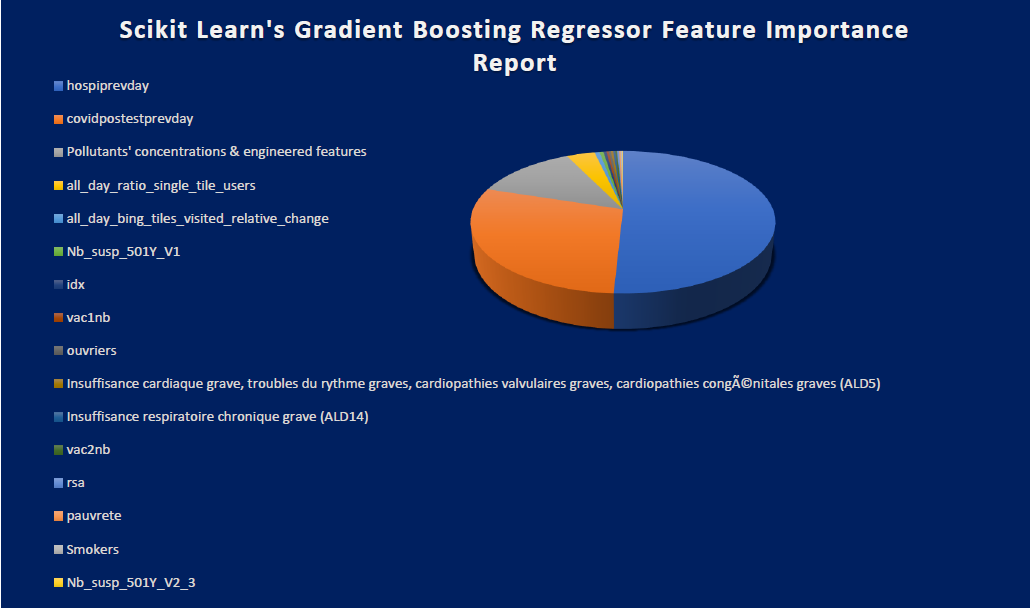

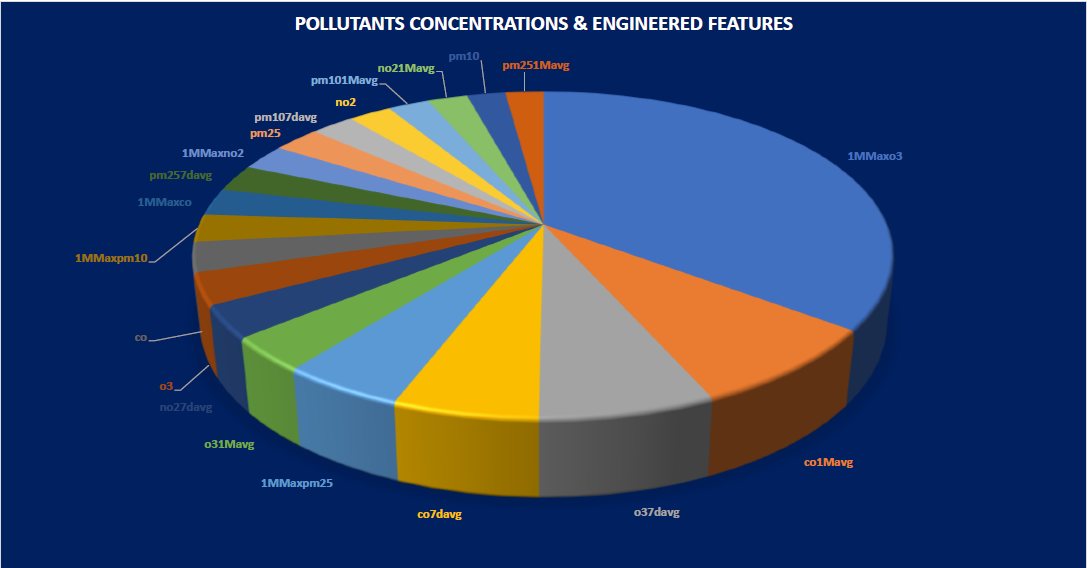

In [ ]:
#exported_pipeline = GradientBoostingRegressor(alpha=0.85, learning_rate=0.1, loss="lad", max_depth=8, max_features=1.0, min_samples_leaf=5, min_samples_split=9, n_estimators=100, subsample=0.6500000000000001)
#exported_pipeline.fit(X2, y)
model = GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, loss="huber", max_depth=8, max_features=1.0, min_samples_leaf=19, min_samples_split=11, n_estimators=100, subsample=0.9500000000000001)
model.fit(X2,y)
print("Scikit Learn - GradientBoostingRegressor:")
FIlist = model.feature_importances_.tolist()
FIlistdf = pd.DataFrame(FIlist)
FIlistdf = FIlistdf.T
FIlistdf.columns = featurespm25
FIlistdf = FIlistdf.T.reset_index()
FIlistdf.columns = ["index","feature_importance"]
FIlistdf.sort_values(by = ["feature_importance"], inplace = True, ascending =True)
print(FIlistdf)
print("\n")
fig = plt.figure(dpi = 150)
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40) 
FIlistdf.plot.barh(x="index", y="feature_importance",figsize = (50,50))
plt.show() 
FIlistdf.to_csv("../feature_importance.csv")

### Exporting the model to a joblib file

In [ ]:
#Save model to .joblib file
# save the model to disk
filename = '../model/model.joblib'
joblib.dump(exported_pipeline, filename)
 
# # some time later...
 
# # load the model from disk
# loaded_model = joblib.load(filename)
# result = loaded_model.score(X_test, Y_test)
# print(result)


### Running T-POT Auto ML optimization algorithm

In [ ]:






print("\n")
print("TPOTRegressor")
tpot = TPOTRegressor(generations=50, population_size=50, verbosity=1, random_state=42)
tpot.fit(X2, y)
print(tpot.score(X_test2, y_test2))
tpot.export('tpot_covid_pipeline.py')

print("\n")


### Recurrent Neural Network

In [ ]:
print("Neural Network")
X_trainNN = X_train2.values.reshape(X_train2.shape[0], X_train2.shape[1], 1)
y_trainNN = y_train2.values
X_testNN = X_test2.values.reshape(X_test2.shape[0],X_test2.shape[1],1)
y_testNN = y_test2.values
NNmodel = Sequential()
#NNmodel.add(layers.Dense(215, input_shape=(X_trainNN.shape[0], X_trainNN.shape[1])))
NNmodel.add(layers.LSTM(units=22, activation='tanh',return_sequences=True, input_shape=X_trainNN.shape[1:]))
NNmodel.add(layers.LSTM(units=10, activation='tanh', return_sequences=False))
NNmodel.add(layers.Dense(1, activation="linear"))

# The compilation
NNmodel.compile(loss='mse', 
              optimizer='rmsprop')

es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)

# The fit
NNmodel.fit(X_trainNN, y_trainNN,
         batch_size=16, validation_split = 0.3,
         epochs=100, verbose=1,callbacks=[es])

# The prediction
print("MSE:")
print(NNmodel.evaluate(X_testNN, y_testNN, verbose=0))

#print('validation loss (MSE):', val_loss, '\n validation MAE:', val_mae)
#print("Average error on new number of hospitalizations per day:", round(val_mae ** 0.5,0))

## A classification of pollution levels, using the elbow method to get the optimal number of clusters

### The KMeans elbow method

In [ ]:
dfnew = df[["pm25"]]

In [ ]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(dfnew)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow method determines that the optimal number of clusters for PM2.5 Levels is k = 4

### Finding minima in the kernel density estimation to identify splitting points, and describe the resulting ranges as (min,max) intervals

In [3]:
minpm25 = df["pm25"].min()
print(minpm25)
maxpm25 = df["pm25"].max()
print(maxpm25)
increment = (maxpm25 - minpm25)/4
pm25levelslist =[]
for i in range(5):
    pm25levelslist.append(minpm25 + i * increment)
print(pm25levelslist)

def pm25levels(row):
    pm25 = row['pm25']
    
    if (pm25 <= pm25levelslist[1]):
        level = 0
        levelstring = "Low"
    elif ((pm25levelslist[1] < pm25) & (pm25levelslist[2] >= pm25)):
        level = 1
        levelstring = "Medium"
    elif ((pm25levelslist[2] < pm25) & (pm25levelslist[3] >= pm25)):
        level = 2
        levelstring = "High"
    else:
        level = 3
        levelstring = "Very High"
          
    return (level, levelstring)

def pm25levels_to_df(data):
    data[["pm25level","pm25levelstring"]] \
                = data.apply(pm25levels, axis=1).apply(pd.Series)
    print("\n")
    return data

df =  pm25levels_to_df(df)
print(df[(df['date']==pd.to_datetime('2021-04-21')) & ((df["pm25levelstring"]=="High")|(df["pm25levelstring"]=="Very High"))][["nom","pm25levelstring"]])
df.to_csv("../data/train/all_data_merged/fr/Enriched_Covid_history_data.csv", index = False)
print('OK')
print(df[df["date"]==pd.to_datetime('2021-04-21')]["pm25levelstring"])


0.5151065130746879
40.233186174790944
[0.5151065130746879, 10.444626428503753, 20.374146343932818, 30.303666259361883, 40.233186174790944]


Empty DataFrame
Columns: [nom, pm25levelstring]
Index: []
OK
Series([], Name: pm25levelstring, dtype: object)


## Conclusion & Visual Outputs


In [ ]:
import seaborn as sns
datapairplot = df[["1MMaxpm25","newhospi","pm257davg","pm107davg","1MMaxno2","1MMaxo3", "1MMaxco"]]

In [ ]:
sns.pairplot(datapairplot)

### Design & Development:



* Part of our product is dedicated to predicting the daily new derpartmental number of hospitalizations due to severe cases of COVID19, these predictions are made by a state of the art Machine Learning model, fine tuned by an Auto Machine Learning optimizer, and are necessary for hospitals and clinics to potentially organize emergency outflows of patients to other locations in case of over-crowding.
 
* The virus' contagious characteristic and facebook's mobility index lead our model's feature importance report but data visualizationg makes it clear to the eye that the mean of all french departments' new hospitalizations due to severe COVID-19 cases is an increasing function of PM2.5-1-M Maximum and PM10 7-day average differentials. Furthermore, unusually high levels in Ozone at ground level seem to act as a trigger to the epidemy.

* Our model makes predictions based on live data flows, composed of a set of 22 features, some such as ground level atmospheric pollutant concentrations, others reflecting prevalence/incidence of variants, others the impact of the vaccination campaign and soon temperature and humidity data.

* Our algorithm is first trained on a maximum depth historical database obtained by merging features streamed from a multitude of data sources/providers in our database. The training of the model will frequently be launched with the goal that the algorithm continues learning from new data. An API will load the latest model and feed directly all the necessary outputs, including the integration of GIS elements, to the company's product website.

* Our tool also ranks French departments by their pollution levels and gives alerts when PM2.5, PM10 or/and other pollutants levels are abnormally high, determining an optimal number of levels is with the K-Means clustering elbow method. These alerts are translated into recommendations with the goal that the government automatically takes measures to stop heavy traffic pollution coming from non electrical cars and trucks until the monitoring team determines that the live levels in pollutants have lowered to a safe cluster interval.



### Verification of methodology

* Automated Error reports comparing ground truth to predictions keep track of a history of MSEs and MAEs, this will allow the monitoring team to day after day check the evolution of our predictions' precision. We have cross-validated our results on a dataset of 30912 data entries and we obtain a MAE of approximately 4 new daily hospitalizations per department.

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# =============================================================================
# Imports
# =============================================================================
#part| #%%
import sys

import datetime
import numpy as np
import pandas as pd
import xarray as xr
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import io
import imageio


grayDark = '#e1e1e1'
grayLight = '#404040'

sns.set(
	context 	= 'paper',
	style 		= 'dark',
	palette 	= 'muted',
	color_codes = True,
    font_scale  = 2.0,
	font 		= 'sans-serif',
	rc={
		'axes.edgecolor'	: grayDark
		,'text.color' 		: grayDark
		,'axes.labelcolor' 	: grayDark
		,'xtick.color' 		: grayDark
		,'ytick.color' 		: grayDark
        ,'figure.facecolor' : grayLight
        ,'axes.facecolor'   : grayLight
        ,'savefig.facecolor': grayLight
		#,'figure.subplot.left' 		: 0.1 # 0.125
		#,'figure.subplot.right' 	: 0.95 # 0.9
		#,'figure.subplot.top' 		: 0.90 # 0.88
		#,'figure.subplot.bottom' 	: 0.11 # 0.11
		#,'figure.subplot.wspace' 	: 0.2 # 0.2
		#,'figure.subplot.hspace' 	: 0.2 # 0.2
		#,'text.usetex':True
		#,'text.latex.preamble':[
		#	r'\usepackage{cmbright}', 	# set font; for Helvetica use r'\usepackage{helvet}'
		#	r'\usepackage{relsize}',
		#	r'\usepackage{upgreek}',
		#	r'\usepackage{amsmath}'
		#	r'\usepackage{siunitx}',
		#	r'\usepackage{physics}',
		#	r'\usepackage{wasysym}', 	# permil symbol in mathmode: \permil
		#	r'\usepackage{textcomp}', 	# permil symbol: \textperthousand
		#	r'\usepackage{mathtools}',
		#	r'\setlength\parindent{0pt}'
		#	]
		}
)

#endpart

# =============================================================================
# Functions
# =============================================================================
#part|
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()
#endpart

# =============================================================================
# Data
# =============================================================================
print('Data pre-processing:', flush=True)
#part|
countryBorders = cfeature.NaturalEarthFeature(
    category    = 'cultural',
    name        = 'ne_admin_0_countries',
    scale       = '10m',
    facecolor   = 'none'
)

countryEU = regionmask.defined_regions.natural_earth.countries_50

currentDate = datetime.datetime.today().strftime('%Y-%m-%d')

# Population
# -----------------------------------------------------------------------------
  #section| #%%
print('Population ... ', flush=True, end='')
pop         = pd.read_csv('../data/pop/fr/pop.csv', usecols=[0,1,2,3,4,5,6,42])
pop.columns = ['reg', 'dep', 'com', 'article', 'com_nom', 'lon', 'lat', 'total']
popDEP          = pop.copy().groupby('dep').median()
popDEP['total'] = pop.groupby('dep').sum()['total']

# Population Index
# Min-Max-normalized values of the log10 transformation
pop['idx']    = normalize(np.log10(pop['total']))
popDEP['idx'] = normalize(np.log10(popDEP['total']))
print('OK', flush=True)
  #endsection

# Covid
# -----------------------------------------------------------------------------
  #section| #%%
print('Covid ... ', flush=True, end='')
filePath = '../data/train/covid/fr/'
fileName = 'Covid_data_history.csv'
covid = pd.read_csv(filePath + fileName, sep=',').dropna()

# take 1-week moving average and take today's values
covid = covid.groupby('numero').rolling(window=7).mean()
covid = covid.groupby(level=0).tail(1).reset_index(drop=True)

popSubset = pop[['lon','lat','dep']].drop_duplicates(subset=['dep'])
covid['lon'] = [popSubset[popSubset['dep']==int(depNum)].lon.values.squeeze() for depNum in covid['numero']]
covid['lat'] = [popSubset[popSubset['dep']==int(depNum)].lat.values.squeeze() for depNum in covid['numero']]
# remove French oversea departments
covid = covid[:-5]

# extrapolate covid cases from deprtement to commune level
covidExtraToCom = pop.copy()
covidExtraToCom['hospi'] = [covid[covid['numero'] == depNum].hospi.values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['idx']  = covidExtraToCom['hospi'].where(covidExtraToCom.hospi>200,(covidExtraToCom.hospi/200)).where(covidExtraToCom.hospi<=200,1)
print('OK', flush=True)
  #endsection

# PM2.5
# -----------------------------------------------------------------------------
  #section| #%%
print('o3 ... ', flush=True, end='')
filePath = '../data/train/cams/fr/analysis/'
fileName = "cams-forecast-2021-04-17.nc"
o3 = xr.open_dataset(filePath + fileName)
o3 = o3.o3_conc
o3.coords['longitude'] = (o3.coords['longitude'] + 180) % 360 - 180
o3 = o3.sortby('longitude')
o3 = o3.sel(longitude=slice(-10,10),latitude=slice(55,40))
# o3Norm = o3.where(o3>10,0).where(o3<20,1).where(o3<10, (o3/10 - 1))
# o3 = o3Norm.where(o3Norm<1,0)
print('OK')
  #endsection

#endpart


# =============================================================================
# Interpolation
# =============================================================================
# We have to interpolate PM2.5 data from the gridded field
# to the irregular grid points of regions/departments/communities
# You may set a filter (takeEvery) which reduces the number of regions taken
# into account if compuational cost is to high
#part| #%%
takeEvery = 1
lons, lats = pop.lon, pop.lat
xrLons = xr.DataArray(lons, dims='com')
xrLats = xr.DataArray(lats, dims='com')
o3Interpolated = o3.interp(longitude=xrLons, latitude=xrLats)

#endpart


# =============================================================================
# Risk Assessment
# =============================================================================
#part| #%%
riskMaps = []
#for lead in progressbar(range(97), 'Compute risk: ', 60):
risk = o3Interpolated
#risk = risk**(1/3)
risk = np.array(risk)
risk = np.vstack((lons,lats,risk))
risk = risk.T

risk = pd.DataFrame(risk, columns = ['lon', 'lat', 'idx'])

riskMaps.append(risk)
#endpart



# =============================================================================
# Create Figures
# =============================================================================
#part| #%%
markersize = .1
images = []



fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
axes = [ax1]
ax1.background_patch.set_fill(False)
for a in axes:
    a.add_geometries(countryEU['F'].polygon, ccrs.PlateCarree(),
    edgecolor=grayDark, lw=2, facecolor=grayDark, alpha=0.6, zorder=0)
    a.set_extent([-5,10,41,52])
    a.set_aspect('auto')
    a.outline_patch.set_linewidth(0.)
    pass

cax = ax1.scatter(riskMaps[0].lon,riskMaps[0].lat,c=riskMaps[0].idx,
cmap='RdYlGn_r', s=markersize*5, vmin=0, vmax=df["o3"].max(), zorder=4)
cbar = fig.colorbar(cax, orientation='horizontal', pad=0, aspect=50,
fraction=.01, extend='max', drawedges=False, ticks=[0, df["o3"].max()])
cbar.ax.set_xticklabels(['low', 'high'])
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

ax1.text(0,.0,'Data \nCAMS \ndata.gouv.fr', transform=ax1.transAxes,fontdict={'size':12})

currentDateWD = datetime.datetime.strptime(currentDate, '%Y-%m-%d').strftime('%a, %d %b %Y')
ax1.set_title('O3 concentrations \n{:}\n'.format(currentDateWD),
loc='left', pad=-60)

fig.subplots_adjust(bottom=.01, left=.01, right=.99, top=.99)
plt.show()
#buffer = io.BytesIO()
# plt.savefig(buffer, format='png', dpi=70)
# buffer.seek(0)
# images.append(imageio.imread(buffer))
# buffer.close()
# plt.close()

#endpart

# print('Create gif ...', flush=True, end='')
# gifPath = '../forecast/fr/'
# gifName = 'covid-risk-fc-{:}.gif'.format(currentDate)
# kargs = { 'duration': .2 }
# imageio.mimwrite(gifPath + gifName, images, 'GIF', **kargs)
# print('OK')
# print('Finished.')


### Nitrogen Dioxide Concentrations Heat Map

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# =============================================================================
# Imports
# =============================================================================
#part| #%%
import sys

import datetime
import numpy as np
import pandas as pd
import xarray as xr
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import io
import imageio


grayDark = '#e1e1e1'
grayLight = '#404040'

sns.set(
	context 	= 'paper',
	style 		= 'dark',
	palette 	= 'muted',
	color_codes = True,
    font_scale  = 2.0,
	font 		= 'sans-serif',
	rc={
		'axes.edgecolor'	: grayDark
		,'text.color' 		: grayDark
		,'axes.labelcolor' 	: grayDark
		,'xtick.color' 		: grayDark
		,'ytick.color' 		: grayDark
        ,'figure.facecolor' : grayLight
        ,'axes.facecolor'   : grayLight
        ,'savefig.facecolor': grayLight
		#,'figure.subplot.left' 		: 0.1 # 0.125
		#,'figure.subplot.right' 	: 0.95 # 0.9
		#,'figure.subplot.top' 		: 0.90 # 0.88
		#,'figure.subplot.bottom' 	: 0.11 # 0.11
		#,'figure.subplot.wspace' 	: 0.2 # 0.2
		#,'figure.subplot.hspace' 	: 0.2 # 0.2
		#,'text.usetex':True
		#,'text.latex.preamble':[
		#	r'\usepackage{cmbright}', 	# set font; for Helvetica use r'\usepackage{helvet}'
		#	r'\usepackage{relsize}',
		#	r'\usepackage{upgreek}',
		#	r'\usepackage{amsmath}'
		#	r'\usepackage{siunitx}',
		#	r'\usepackage{physics}',
		#	r'\usepackage{wasysym}', 	# permil symbol in mathmode: \permil
		#	r'\usepackage{textcomp}', 	# permil symbol: \textperthousand
		#	r'\usepackage{mathtools}',
		#	r'\setlength\parindent{0pt}'
		#	]
		}
)

#endpart

# =============================================================================
# Functions
# =============================================================================
#part|
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()
#endpart

# =============================================================================
# Data
# =============================================================================
print('Data pre-processing:', flush=True)
#part|
countryBorders = cfeature.NaturalEarthFeature(
    category    = 'cultural',
    name        = 'ne_admin_0_countries',
    scale       = '10m',
    facecolor   = 'none'
)

countryEU = regionmask.defined_regions.natural_earth.countries_50

currentDate = datetime.datetime.today().strftime('%Y-%m-%d')

# Population
# -----------------------------------------------------------------------------
  #section| #%%
print('Population ... ', flush=True, end='')
pop         = pd.read_csv('../data/pop/fr/pop.csv', usecols=[0,1,2,3,4,5,6,42])
pop.columns = ['reg', 'dep', 'com', 'article', 'com_nom', 'lon', 'lat', 'total']
popDEP          = pop.copy().groupby('dep').median()
popDEP['total'] = pop.groupby('dep').sum()['total']

# Population Index
# Min-Max-normalized values of the log10 transformation
pop['idx']    = normalize(np.log10(pop['total']))
popDEP['idx'] = normalize(np.log10(popDEP['total']))
print('OK', flush=True)
  #endsection

# Covid
# -----------------------------------------------------------------------------
  #section| #%%
print('Covid ... ', flush=True, end='')
filePath = '../data/train/covid/fr/'
fileName = 'Covid_data_history.csv'
covid = pd.read_csv(filePath + fileName, sep=',').dropna()

# take 1-week moving average and take today's values
covid = covid.groupby('numero').rolling(window=7).mean()
covid = covid.groupby(level=0).tail(1).reset_index(drop=True)

popSubset = pop[['lon','lat','dep']].drop_duplicates(subset=['dep'])
covid['lon'] = [popSubset[popSubset['dep']==int(depNum)].lon.values.squeeze() for depNum in covid['numero']]
covid['lat'] = [popSubset[popSubset['dep']==int(depNum)].lat.values.squeeze() for depNum in covid['numero']]
# remove French oversea departments
covid = covid[:-5]

# extrapolate covid cases from deprtement to commune level
covidExtraToCom = pop.copy()
covidExtraToCom['hospi'] = [covid[covid['numero'] == depNum].hospi.values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['idx']  = covidExtraToCom['hospi'].where(covidExtraToCom.hospi>200,(covidExtraToCom.hospi/200)).where(covidExtraToCom.hospi<=200,1)
print('OK', flush=True)
  #endsection

# PM2.5
# -----------------------------------------------------------------------------
  #section| #%%
print('no2 ... ', flush=True, end='')
filePath = '../data/train/cams/fr/analysis/'
fileName = "cams-forecast-2021-04-17.nc"
no2 = xr.open_dataset(filePath + fileName)
no2 = no2.no2_conc
no2.coords['longitude'] = (no2.coords['longitude'] + 180) % 360 - 180
no2 = no2.sortby('longitude')
no2 = no2.sel(longitude=slice(-10,10),latitude=slice(55,40))
# no2Norm = no2.where(no2>10,0).where(no2<20,1).where(no2<10, (no2/10 - 1))
# no2 = no2Norm.where(no2Norm<1,0)
print('OK')
  #endsection

#endpart


# =============================================================================
# Interpolation
# =============================================================================
# We have to interpolate PM2.5 data from the gridded field
# to the irregular grid points of regions/departments/communities
# You may set a filter (takeEvery) which reduces the number of regions taken
# into account if compuational cost is to high
#part| #%%
takeEvery = 1
lons, lats = pop.lon, pop.lat
xrLons = xr.DataArray(lons, dims='com')
xrLats = xr.DataArray(lats, dims='com')
no2Interpolated = no2.interp(longitude=xrLons, latitude=xrLats)

#endpart


# =============================================================================
# Risk Assessment
# =============================================================================
#part| #%%
riskMaps = []
#for lead in progressbar(range(97), 'Compute risk: ', 60):
risk = no2Interpolated
#risk = risk**(1/3)
risk = np.array(risk)
risk = np.vstack((lons,lats,risk))
risk = risk.T

risk = pd.DataFrame(risk, columns = ['lon', 'lat', 'idx'])

riskMaps.append(risk)
#endpart



# =============================================================================
# Create Figures
# =============================================================================
#part| #%%
markersize = .1
images = []



fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
axes = [ax1]
ax1.background_patch.set_fill(False)
for a in axes:
    a.add_geometries(countryEU['F'].polygon, ccrs.PlateCarree(),
    edgecolor=grayDark, lw=2, facecolor=grayDark, alpha=0.6, zorder=0)
    a.set_extent([-5,10,41,52])
    a.set_aspect('auto')
    a.outline_patch.set_linewidth(0.)
    pass

cax = ax1.scatter(riskMaps[0].lon,riskMaps[0].lat,c=riskMaps[0].idx,
cmap='RdYlGn_r', s=markersize*5, vmin=0, vmax=df["no2"].max(), zorder=4)
cbar = fig.colorbar(cax, orientation='horizontal', pad=0, aspect=50,
fraction=.01, extend='max', drawedges=False, ticks=[0, df["no2"].max()])
cbar.ax.set_xticklabels(['low', 'high'])
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

ax1.text(0,.0,'Data \nCAMS \ndata.gouv.fr', transform=ax1.transAxes,fontdict={'size':12})

currentDateWD = datetime.datetime.strptime(currentDate, '%Y-%m-%d').strftime('%a, %d %b %Y')
ax1.set_title('no2 concentrations \n{:}\n'.format(currentDateWD),
loc='left', pad=-60)

fig.subplots_adjust(bottom=.01, left=.01, right=.99, top=.99)
plt.show()
#buffer = io.BytesIO()
# plt.savefig(buffer, format='png', dpi=70)
# buffer.seek(0)
# images.append(imageio.imread(buffer))
# buffer.close()
# plt.close()

#endpart

# print('Create gif ...', flush=True, end='')
# gifPath = '../forecast/fr/'
# gifName = 'covid-risk-fc-{:}.gif'.format(currentDate)
# kargs = { 'duration': .2 }
# imageio.mimwrite(gifPath + gifName, images, 'GIF', **kargs)
# print('OK')
# print('Finished.')


### PM10 Concentrations Heat Map

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# =============================================================================
# Imports
# =============================================================================
#part| #%%
import sys

import datetime
import numpy as np
import pandas as pd
import xarray as xr
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import io
import imageio


grayDark = '#e1e1e1'
grayLight = '#404040'

sns.set(
	context 	= 'paper',
	style 		= 'dark',
	palette 	= 'muted',
	color_codes = True,
    font_scale  = 2.0,
	font 		= 'sans-serif',
	rc={
		'axes.edgecolor'	: grayDark
		,'text.color' 		: grayDark
		,'axes.labelcolor' 	: grayDark
		,'xtick.color' 		: grayDark
		,'ytick.color' 		: grayDark
        ,'figure.facecolor' : grayLight
        ,'axes.facecolor'   : grayLight
        ,'savefig.facecolor': grayLight
		#,'figure.subplot.left' 		: 0.1 # 0.125
		#,'figure.subplot.right' 	: 0.95 # 0.9
		#,'figure.subplot.top' 		: 0.90 # 0.88
		#,'figure.subplot.bottom' 	: 0.11 # 0.11
		#,'figure.subplot.wspace' 	: 0.2 # 0.2
		#,'figure.subplot.hspace' 	: 0.2 # 0.2
		#,'text.usetex':True
		#,'text.latex.preamble':[
		#	r'\usepackage{cmbright}', 	# set font; for Helvetica use r'\usepackage{helvet}'
		#	r'\usepackage{relsize}',
		#	r'\usepackage{upgreek}',
		#	r'\usepackage{amsmath}'
		#	r'\usepackage{siunitx}',
		#	r'\usepackage{physics}',
		#	r'\usepackage{wasysym}', 	# permil symbol in mathmode: \permil
		#	r'\usepackage{textcomp}', 	# permil symbol: \textperthousand
		#	r'\usepackage{mathtools}',
		#	r'\setlength\parindent{0pt}'
		#	]
		}
)

#endpart

# =============================================================================
# Functions
# =============================================================================
#part|
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()
#endpart

# =============================================================================
# Data
# =============================================================================
print('Data pre-processing:', flush=True)
#part|
countryBorders = cfeature.NaturalEarthFeature(
    category    = 'cultural',
    name        = 'ne_admin_0_countries',
    scale       = '10m',
    facecolor   = 'none'
)

countryEU = regionmask.defined_regions.natural_earth.countries_50

currentDate = datetime.datetime.today().strftime('%Y-%m-%d')

# Population
# -----------------------------------------------------------------------------
  #section| #%%
print('Population ... ', flush=True, end='')
pop         = pd.read_csv('../data/pop/fr/pop.csv', usecols=[0,1,2,3,4,5,6,42])
pop.columns = ['reg', 'dep', 'com', 'article', 'com_nom', 'lon', 'lat', 'total']
popDEP          = pop.copy().groupby('dep').median()
popDEP['total'] = pop.groupby('dep').sum()['total']

# Population Index
# Min-Max-normalized values of the log10 transformation
pop['idx']    = normalize(np.log10(pop['total']))
popDEP['idx'] = normalize(np.log10(popDEP['total']))
print('OK', flush=True)
  #endsection

# Covid
# -----------------------------------------------------------------------------
  #section| #%%
print('Covid ... ', flush=True, end='')
filePath = '../data/train/covid/fr/'
fileName = 'Covid_data_history.csv'
covid = pd.read_csv(filePath + fileName, sep=',').dropna()

# take 1-week moving average and take today's values
covid = covid.groupby('numero').rolling(window=7).mean()
covid = covid.groupby(level=0).tail(1).reset_index(drop=True)

popSubset = pop[['lon','lat','dep']].drop_duplicates(subset=['dep'])
covid['lon'] = [popSubset[popSubset['dep']==int(depNum)].lon.values.squeeze() for depNum in covid['numero']]
covid['lat'] = [popSubset[popSubset['dep']==int(depNum)].lat.values.squeeze() for depNum in covid['numero']]
# remove French oversea departments
covid = covid[:-5]

# extrapolate covid cases from deprtement to commune level
covidExtraToCom = pop.copy()
covidExtraToCom['hospi'] = [covid[covid['numero'] == depNum].hospi.values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['idx']  = covidExtraToCom['hospi'].where(covidExtraToCom.hospi>200,(covidExtraToCom.hospi/200)).where(covidExtraToCom.hospi<=200,1)
print('OK', flush=True)
  #endsection

# PM2.5
# -----------------------------------------------------------------------------
  #section| #%%
print('pm10 ... ', flush=True, end='')
filePath = '../data/train/cams/fr/analysis/'
fileName = "cams-forecast-2021-04-17.nc"
pm10 = xr.open_dataset(filePath + fileName)
pm10 = pm10.pm10_conc
pm10.coords['longitude'] = (pm10.coords['longitude'] + 180) % 360 - 180
pm10 = pm10.sortby('longitude')
pm10 = pm10.sel(longitude=slice(-10,10),latitude=slice(55,40))
# pm10Norm = pm10.where(pm10>10,0).where(pm10<20,1).where(pm10<10, (pm10/10 - 1))
# pm10 = pm10Norm.where(pm10Norm<1,0)
print('OK')
  #endsection

#endpart


# =============================================================================
# Interpolation
# =============================================================================
# We have to interpolate PM2.5 data from the gridded field
# to the irregular grid points of regions/departments/communities
# You may set a filter (takeEvery) which reduces the number of regions taken
# into account if compuational cost is to high
#part| #%%
takeEvery = 1
lons, lats = pop.lon, pop.lat
xrLons = xr.DataArray(lons, dims='com')
xrLats = xr.DataArray(lats, dims='com')
pm10Interpolated = pm10.interp(longitude=xrLons, latitude=xrLats)

#endpart


# =============================================================================
# Risk Assessment
# =============================================================================
#part| #%%
riskMaps = []
#for lead in progressbar(range(97), 'Compute risk: ', 60):
risk = pm10Interpolated
#risk = risk**(1/3)
risk = np.array(risk)
risk = np.vstack((lons,lats,risk))
risk = risk.T

risk = pd.DataFrame(risk, columns = ['lon', 'lat', 'idx'])

riskMaps.append(risk)
#endpart



# =============================================================================
# Create Figures
# =============================================================================
#part| #%%
markersize = .1
images = []



fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
axes = [ax1]
ax1.background_patch.set_fill(False)
for a in axes:
    a.add_geometries(countryEU['F'].polygon, ccrs.PlateCarree(),
    edgecolor=grayDark, lw=2, facecolor=grayDark, alpha=0.6, zorder=0)
    a.set_extent([-5,10,41,52])
    a.set_aspect('auto')
    a.outline_patch.set_linewidth(0.)
    pass

cax = ax1.scatter(riskMaps[0].lon,riskMaps[0].lat,c=riskMaps[0].idx,
cmap='RdYlGn_r', s=markersize*5, vmin=0, vmax=df["pm10"].max(), zorder=4)
cbar = fig.colorbar(cax, orientation='horizontal', pad=0, aspect=50,
fraction=.01, extend='max', drawedges=False, ticks=[0, df["pm10"].max()])
cbar.ax.set_xticklabels(['low', 'high'])
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

ax1.text(0,.0,'Data \nCAMS \ndata.gouv.fr', transform=ax1.transAxes,fontdict={'size':12})

currentDateWD = datetime.datetime.strptime(currentDate, '%Y-%m-%d').strftime('%a, %d %b %Y')
ax1.set_title('pm10 concentrations \n{:}\n'.format(currentDateWD),
loc='left', pad=-60)

fig.subplots_adjust(bottom=.01, left=.01, right=.99, top=.99)
plt.show()
#buffer = io.BytesIO()
# plt.savefig(buffer, format='png', dpi=70)
# buffer.seek(0)
# images.append(imageio.imread(buffer))
# buffer.close()
# plt.close()

#endpart

# print('Create gif ...', flush=True, end='')
# gifPath = '../forecast/fr/'
# gifName = 'covid-risk-fc-{:}.gif'.format(currentDate)
# kargs = { 'duration': .2 }
# imageio.mimwrite(gifPath + gifName, images, 'GIF', **kargs)
# print('OK')
# print('Finished.')


### Carbon Monoxide Concentrations Heat Map

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# =============================================================================
# Imports
# =============================================================================
#part| #%%
import sys

import datetime
import numpy as np
import pandas as pd
import xarray as xr
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import io
import imageio


grayDark = '#e1e1e1'
grayLight = '#404040'

sns.set(
	context 	= 'paper',
	style 		= 'dark',
	palette 	= 'muted',
	color_codes = True,
    font_scale  = 2.0,
	font 		= 'sans-serif',
	rc={
		'axes.edgecolor'	: grayDark
		,'text.color' 		: grayDark
		,'axes.labelcolor' 	: grayDark
		,'xtick.color' 		: grayDark
		,'ytick.color' 		: grayDark
        ,'figure.facecolor' : grayLight
        ,'axes.facecolor'   : grayLight
        ,'savefig.facecolor': grayLight
		#,'figure.subplot.left' 		: 0.1 # 0.125
		#,'figure.subplot.right' 	: 0.95 # 0.9
		#,'figure.subplot.top' 		: 0.90 # 0.88
		#,'figure.subplot.bottom' 	: 0.11 # 0.11
		#,'figure.subplot.wspace' 	: 0.2 # 0.2
		#,'figure.subplot.hspace' 	: 0.2 # 0.2
		#,'text.usetex':True
		#,'text.latex.preamble':[
		#	r'\usepackage{cmbright}', 	# set font; for Helvetica use r'\usepackage{helvet}'
		#	r'\usepackage{relsize}',
		#	r'\usepackage{upgreek}',
		#	r'\usepackage{amsmath}'
		#	r'\usepackage{siunitx}',
		#	r'\usepackage{physics}',
		#	r'\usepackage{wasysym}', 	# permil symbol in mathmode: \permil
		#	r'\usepackage{textcomp}', 	# permil symbol: \textperthousand
		#	r'\usepackage{mathtools}',
		#	r'\setlength\parindent{0pt}'
		#	]
		}
)

#endpart

# =============================================================================
# Functions
# =============================================================================
#part|
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()
#endpart

# =============================================================================
# Data
# =============================================================================
print('Data pre-processing:', flush=True)
#part|
countryBorders = cfeature.NaturalEarthFeature(
    category    = 'cultural',
    name        = 'ne_admin_0_countries',
    scale       = '10m',
    facecolor   = 'none'
)

countryEU = regionmask.defined_regions.natural_earth.countries_50

currentDate = datetime.datetime.today().strftime('%Y-%m-%d')

# Population
# -----------------------------------------------------------------------------
  #section| #%%
print('Population ... ', flush=True, end='')
pop         = pd.read_csv('../data/pop/fr/pop.csv', usecols=[0,1,2,3,4,5,6,42])
pop.columns = ['reg', 'dep', 'com', 'article', 'com_nom', 'lon', 'lat', 'total']
popDEP          = pop.copy().groupby('dep').median()
popDEP['total'] = pop.groupby('dep').sum()['total']

# Population Index
# Min-Max-normalized values of the log10 transformation
pop['idx']    = normalize(np.log10(pop['total']))
popDEP['idx'] = normalize(np.log10(popDEP['total']))
print('OK', flush=True)
  #endsection

# Covid
# -----------------------------------------------------------------------------
  #section| #%%
print('Covid ... ', flush=True, end='')
filePath = '../data/train/covid/fr/'
fileName = 'Covid_data_history.csv'
covid = pd.read_csv(filePath + fileName, sep=',').dropna()

# take 1-week moving average and take today's values
covid = covid.groupby('numero').rolling(window=7).mean()
covid = covid.groupby(level=0).tail(1).reset_index(drop=True)

popSubset = pop[['lon','lat','dep']].drop_duplicates(subset=['dep'])
covid['lon'] = [popSubset[popSubset['dep']==int(depNum)].lon.values.squeeze() for depNum in covid['numero']]
covid['lat'] = [popSubset[popSubset['dep']==int(depNum)].lat.values.squeeze() for depNum in covid['numero']]
# remove French oversea departments
covid = covid[:-5]

# extrapolate covid cases from deprtement to commune level
covidExtraToCom = pop.copy()
covidExtraToCom['hospi'] = [covid[covid['numero'] == depNum].hospi.values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['idx']  = covidExtraToCom['hospi'].where(covidExtraToCom.hospi>200,(covidExtraToCom.hospi/200)).where(covidExtraToCom.hospi<=200,1)
print('OK', flush=True)
  #endsection

# PM2.5
# -----------------------------------------------------------------------------
  #section| #%%
print('co ... ', flush=True, end='')
filePath = '../data/train/cams/fr/analysis/'
fileName = "cams-forecast-2021-04-17.nc"
co = xr.open_dataset(filePath + fileName)
co = co.co_conc
co.coords['longitude'] = (co.coords['longitude'] + 180) % 360 - 180
co = co.sortby('longitude')
co = co.sel(longitude=slice(-10,10),latitude=slice(55,40))
# coNorm = co.where(co>10,0).where(co<20,1).where(co<10, (co/10 - 1))
# co = coNorm.where(coNorm<1,0)
print('OK')
  #endsection

#endpart


# =============================================================================
# Interpolation
# =============================================================================
# We have to interpolate PM2.5 data from the gridded field
# to the irregular grid points of regions/departments/communities
# You may set a filter (takeEvery) which reduces the number of regions taken
# into account if compuational cost is to high
#part| #%%
takeEvery = 1
lons, lats = pop.lon, pop.lat
xrLons = xr.DataArray(lons, dims='com')
xrLats = xr.DataArray(lats, dims='com')
coInterpolated = co.interp(longitude=xrLons, latitude=xrLats)

#endpart


# =============================================================================
# Risk Assessment
# =============================================================================
#part| #%%
riskMaps = []
#for lead in progressbar(range(97), 'Compute risk: ', 60):
risk = coInterpolated
#risk = risk**(1/3)
risk = np.array(risk)
risk = np.vstack((lons,lats,risk))
risk = risk.T

risk = pd.DataFrame(risk, columns = ['lon', 'lat', 'idx'])

riskMaps.append(risk)
#endpart



# =============================================================================
# Create Figures
# =============================================================================
#part| #%%
markersize = .1
images = []



fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
axes = [ax1]
ax1.background_patch.set_fill(False)
for a in axes:
    a.add_geometries(countryEU['F'].polygon, ccrs.PlateCarree(),
    edgecolor=grayDark, lw=2, facecolor=grayDark, alpha=0.6, zorder=0)
    a.set_extent([-5,10,41,52])
    a.set_aspect('auto')
    a.outline_patch.set_linewidth(0.)
    pass

cax = ax1.scatter(riskMaps[0].lon,riskMaps[0].lat,c=riskMaps[0].idx,
cmap='RdYlGn_r', s=markersize*5, vmin=0, vmax=df["co"].max(), zorder=4)
cbar = fig.colorbar(cax, orientation='horizontal', pad=0, aspect=50,
fraction=.01, extend='max', drawedges=False, ticks=[0, df["co"].max()])
cbar.ax.set_xticklabels(['low', 'high'])
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

ax1.text(0,.0,'Data \nCAMS \ndata.gouv.fr', transform=ax1.transAxes,fontdict={'size':12})

currentDateWD = datetime.datetime.strptime(currentDate, '%Y-%m-%d').strftime('%a, %d %b %Y')
ax1.set_title('co concentrations \n{:}\n'.format(currentDateWD),
loc='left', pad=-60)

fig.subplots_adjust(bottom=.01, left=.01, right=.99, top=.99)
plt.show()
#buffer = io.BytesIO()
# plt.savefig(buffer, format='png', dpi=70)
# buffer.seek(0)
# images.append(imageio.imread(buffer))
# buffer.close()
# plt.close()

#endpart

# print('Create gif ...', flush=True, end='')
# gifPath = '../forecast/fr/'
# gifName = 'covid-risk-fc-{:}.gif'.format(currentDate)
# kargs = { 'duration': .2 }
# imageio.mimwrite(gifPath + gifName, images, 'GIF', **kargs)
# print('OK')
# print('Finished.')


### PM25 Conentrations Heat Map

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# =============================================================================
# Imports
# =============================================================================
#part| #%%
import sys

import datetime
import numpy as np
import pandas as pd
import xarray as xr
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import io
import imageio


grayDark = '#e1e1e1'
grayLight = '#404040'

sns.set(
	context 	= 'paper',
	style 		= 'dark',
	palette 	= 'muted',
	color_codes = True,
    font_scale  = 2.0,
	font 		= 'sans-serif',
	rc={
		'axes.edgecolor'	: grayDark
		,'text.color' 		: grayDark
		,'axes.labelcolor' 	: grayDark
		,'xtick.color' 		: grayDark
		,'ytick.color' 		: grayDark
        ,'figure.facecolor' : grayLight
        ,'axes.facecolor'   : grayLight
        ,'savefig.facecolor': grayLight
		#,'figure.subplot.left' 		: 0.1 # 0.125
		#,'figure.subplot.right' 	: 0.95 # 0.9
		#,'figure.subplot.top' 		: 0.90 # 0.88
		#,'figure.subplot.bottom' 	: 0.11 # 0.11
		#,'figure.subplot.wspace' 	: 0.2 # 0.2
		#,'figure.subplot.hspace' 	: 0.2 # 0.2
		#,'text.usetex':True
		#,'text.latex.preamble':[
		#	r'\usepackage{cmbright}', 	# set font; for Helvetica use r'\usepackage{helvet}'
		#	r'\usepackage{relsize}',
		#	r'\usepackage{upgreek}',
		#	r'\usepackage{amsmath}'
		#	r'\usepackage{siunitx}',
		#	r'\usepackage{physics}',
		#	r'\usepackage{wasysym}', 	# permil symbol in mathmode: \permil
		#	r'\usepackage{textcomp}', 	# permil symbol: \textperthousand
		#	r'\usepackage{mathtools}',
		#	r'\setlength\parindent{0pt}'
		#	]
		}
)

#endpart

# =============================================================================
# Functions
# =============================================================================
#part|
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()
#endpart

# =============================================================================
# Data
# =============================================================================
print('Data pre-processing:', flush=True)
#part|
countryBorders = cfeature.NaturalEarthFeature(
    category    = 'cultural',
    name        = 'ne_admin_0_countries',
    scale       = '10m',
    facecolor   = 'none'
)

countryEU = regionmask.defined_regions.natural_earth.countries_50

currentDate = datetime.datetime.today().strftime('%Y-%m-%d')

# Population
# -----------------------------------------------------------------------------
  #section| #%%
print('Population ... ', flush=True, end='')
pop         = pd.read_csv('../data/pop/fr/pop.csv', usecols=[0,1,2,3,4,5,6,42])
pop.columns = ['reg', 'dep', 'com', 'article', 'com_nom', 'lon', 'lat', 'total']
popDEP          = pop.copy().groupby('dep').median()
popDEP['total'] = pop.groupby('dep').sum()['total']

# Population Index
# Min-Max-normalized values of the log10 transformation
pop['idx']    = normalize(np.log10(pop['total']))
popDEP['idx'] = normalize(np.log10(popDEP['total']))
print('OK', flush=True)
  #endsection

# Covid
# -----------------------------------------------------------------------------
  #section| #%%
print('Covid ... ', flush=True, end='')
filePath = '../data/train/covid/fr/'
fileName = 'Covid_data_history.csv'
covid = pd.read_csv(filePath + fileName, sep=',').dropna()

# take 1-week moving average and take today's values
covid = covid.groupby('numero').rolling(window=7).mean()
covid = covid.groupby(level=0).tail(1).reset_index(drop=True)


popSubset = pop[['lon','lat','dep']].drop_duplicates(subset=['dep'])
covid['lon'] = [popSubset[popSubset['dep']==int(depNum)].lon.values.squeeze() for depNum in covid['numero']]
covid['lat'] = [popSubset[popSubset['dep']==int(depNum)].lat.values.squeeze() for depNum in covid['numero']]
# remove French oversea departments
covid = covid[:-5]

# extrapolate covid cases from deprtement to commune level
covidExtraToCom = pop.copy()
covidExtraToCom['hospi'] = [covid[covid['numero'] == depNum].hospi.values.squeeze() for depNum in covidExtraToCom['dep']]
#covidExtraToCom['idx']  = covidExtraToCom['hospi'].where(covidExtraToCom.hospi>200,(covidExtraToCom.hospi/200)).where(covidExtraToCom.hospi<=200,1)
covidExtraToCom['idx']  = max_normalize(covidExtraToCom['hospi'])
print('OK', flush=True)
  #endsection

# PM2.5
# -----------------------------------------------------------------------------
  #section| #%%
print('PM2.5 ... ', flush=True, end='')
filePath = '../data/train/cams/fr/analysis/'
fileName = "cams-forecast-2021-04-17.nc"
pm25 = xr.open_dataset(filePath + fileName)
pm25 = pm25.pm2p5_conc
pm25.coords['longitude'] = (pm25.coords['longitude'] + 180) % 360 - 180
pm25 = pm25.sortby('longitude')
pm25 = pm25.sel(longitude=slice(-10,10),latitude=slice(55,40))
# pm25Norm = pm25.where(pm25>10,0).where(pm25<20,1).where(pm25<10, (pm25/10 - 1))
# pm25 = pm25Norm.where(pm25Norm<1,0)
print('OK')
  #endsection

#endpart


# =============================================================================
# Interpolation
# =============================================================================
# We have to interpolate PM2.5 data from the gridded field
# to the irregular grid points of regions/departments/communities
# You may set a filter (takeEvery) which reduces the number of regions taken
# into account if compuational cost is to high
#part| #%%
takeEvery = 1
lons, lats = pop.lon, pop.lat
xrLons = xr.DataArray(lons, dims='com')
xrLats = xr.DataArray(lats, dims='com')
pm25Interpolated = pm25.interp(longitude=xrLons, latitude=xrLats)
#endpart


# =============================================================================
# Risk Assessment
# =============================================================================
#part| #%%
riskMaps = []
#for lead in progressbar(range(97), 'Compute risk: ', 60):
#risk = (pm25Interpolated * pop['idx'] * covidExtraToCom['idx'])
risk = (pm25Interpolated)
#risk = risk**(1/3)
risk = np.array(risk)
risk = np.vstack((lons,lats,risk))
risk = risk.T

risk = pd.DataFrame(risk, columns = ['lon', 'lat', 'idx'])

riskMaps.append(risk)
print(df["pm25"].max())
maxriskmap = (df["pm25"].max())
#endpart



# =============================================================================
# Create Figures
# =============================================================================
#part| #%%
markersize = .1
images = []



fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
axes = [ax1]
ax1.background_patch.set_fill(False)
for a in axes:
    a.add_geometries(countryEU['F'].polygon, ccrs.PlateCarree(),
    edgecolor=grayDark, lw=2, facecolor=grayDark, alpha=0.6, zorder=0)
    a.set_extent([-5,10,41,52])
    a.set_aspect('auto')
    a.outline_patch.set_linewidth(0.)
    pass

cax = ax1.scatter(riskMaps[0].lon,riskMaps[0].lat,c=riskMaps[0].idx,
cmap='RdYlGn_r', s=markersize*5, vmin=0, vmax=maxriskmap, zorder=4)
cbar = fig.colorbar(cax, orientation='horizontal', pad=0, aspect=50,
fraction=.01, extend='max', drawedges=False, ticks=[0, maxriskmap])
cbar.ax.set_xticklabels(['low', 'high'])
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

ax1.text(0,.0,'Data \nCAMS \ndata.gouv.fr', transform=ax1.transAxes,fontdict={'size':12})

currentDateWD = datetime.datetime.strptime(currentDate, '%Y-%m-%d').strftime('%a, %d %b %Y')
ax1.set_title('PM2.5 concentrations\n{:}\n'.format(currentDateWD),
loc='left', pad=-60)

fig.subplots_adjust(bottom=.01, left=.01, right=.99, top=.99)
plt.show()
#buffer = io.BytesIO()
# plt.savefig(buffer, format='png', dpi=70)
# buffer.seek(0)
# images.append(imageio.imread(buffer))
# buffer.close()
# plt.close()

#endpart

# print('Create gif ...', flush=True, end='')
# gifPath = '../forecast/fr/'
# gifName = 'covid-risk-fc-{:}.gif'.format(currentDate)
# kargs = { 'duration': .2 }
# imageio.mimwrite(gifPath + gifName, images, 'GIF', **kargs)
# print('OK')
# print('Finished.')


### New Hospitalizations due to severe cases of COVID19 Predictions by departement map

In [ ]:
from cartopy import crs
import pandas as pd
import geopandas as gpd
from datetime import datetime
sf = gpd.read_file('../departements.geojson')
df2 = pd.read_csv('../predictions/fr/predictions.csv')
sf2 = gpd.read_file('../departements.geojson')
df2["time"]=pd.to_datetime(df2["time"])
df3 = df2[df2["time"]==df2["time"].max()]
df3 = df3.sort_values(by = "depnum").reset_index()
sf2['code'] = sf['code'].replace({'2A':'201','2B':'202'}).astype(int)
sf3 = sf2.merge(df3, left_on = "code", right_on = "depnum",suffixes=('','_y'))
sf3 = sf3.merge(sf, on = "nom",suffixes=('_x','') )
sf3 = sf3.drop(columns = ["code_x", "geometry_x", "index","depnum","time"])
sf3['code'] = sf3['code'].replace({'2A':'201','2B':'202'}) 
fig, ax = plt.subplots(1, 0,figsize=(20, 10))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax.background_patch.set_fill(False)
ax.add_geometries(countryEU['F'].polygon, ccrs.PlateCarree(),
edgecolor=grayDark, lw=2, facecolor=grayDark, alpha=0.6, zorder=0)
ax.set_extent([-5,10,41,52])
ax.set_aspect('auto')
ax.outline_patch.set_linewidth(0.)
currentDate = datetime.today().strftime('%Y-%m-%d')
currentDateWD = datetime.strptime(currentDate, '%Y-%m-%d').strftime('%a, %d %b %Y')
ax.set_title('Forecasted number of severe Covid-19 cases leading to \nnew hospitalizations\n{:}\n'.format(currentDateWD), loc='left', pad=-60)
ax.text(0,.0,'Data \nCAMS \ndata.gouv.fr', transform=ax.transAxes,fontdict={'size':12})
sf3.plot(column='newhospipred', ax=ax, legend=True,cmap='RdYlGn_r')

In [ ]:
dfpollution2 = pd.read_csv("../data/train/all_data_merged/fr/Enriched_Covid_history_data.csv")
dfpollution2.dropna(inplace = True)

### Risk heat map for severe Covid19 cases leading to hospitalizations

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# =============================================================================
# Imports
# =============================================================================
#part| #%%
import sys

import datetime
import numpy as np
import pandas as pd
import xarray as xr
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import io
import imageio


grayDark = '#e1e1e1'
grayLight = '#404040'

sns.set(
	context 	= 'paper',
	style 		= 'dark',
	palette 	= 'muted',
	color_codes = True,
    font_scale  = 2.0,
	font 		= 'sans-serif',
	rc={
		'axes.edgecolor'	: grayDark
		,'text.color' 		: grayDark
		,'axes.labelcolor' 	: grayDark
		,'xtick.color' 		: grayDark
		,'ytick.color' 		: grayDark
        ,'figure.facecolor' : grayLight
        ,'axes.facecolor'   : grayLight
        ,'savefig.facecolor': grayLight
		#,'figure.subplot.left' 		: 0.1 # 0.125
		#,'figure.subplot.right' 	: 0.95 # 0.9
		#,'figure.subplot.top' 		: 0.90 # 0.88
		#,'figure.subplot.bottom' 	: 0.11 # 0.11
		#,'figure.subplot.wspace' 	: 0.2 # 0.2
		#,'figure.subplot.hspace' 	: 0.2 # 0.2
		#,'text.usetex':True
		#,'text.latex.preamble':[
		#	r'\usepackage{cmbright}', 	# set font; for Helvetica use r'\usepackage{helvet}'
		#	r'\usepackage{relsize}',
		#	r'\usepackage{upgreek}',
		#	r'\usepackage{amsmath}'
		#	r'\usepackage{siunitx}',
		#	r'\usepackage{physics}',
		#	r'\usepackage{wasysym}', 	# permil symbol in mathmode: \permil
		#	r'\usepackage{textcomp}', 	# permil symbol: \textperthousand
		#	r'\usepackage{mathtools}',
		#	r'\setlength\parindent{0pt}'
		#	]
		}
)

#endpart

# =============================================================================
# Functions
# =============================================================================
#part|
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()
#endpart

# =============================================================================
# Data
# =============================================================================
print('Data pre-processing:', flush=True)
#part|
countryBorders = cfeature.NaturalEarthFeature(
    category    = 'cultural',
    name        = 'ne_admin_0_countries',
    scale       = '10m',
    facecolor   = 'none'
)

countryEU = regionmask.defined_regions.natural_earth.countries_50

currentDate = datetime.datetime.today().strftime('%Y-%m-%d')

# Population
# -----------------------------------------------------------------------------
  #section| #%%
print('Population ... ', flush=True, end='')
pop         = pd.read_csv('../data/pop/fr/pop.csv', usecols=[0,1,2,3,4,5,6,42])
pop.columns = ['reg', 'dep', 'com', 'article', 'com_nom', 'lon', 'lat', 'total']
popDEP          = pop.copy().groupby('dep').median()
popDEP['total'] = pop.groupby('dep').sum()['total']

# Population Index
# Min-Max-normalized values of the log10 transformation
pop['idx']    = normalize((pop['total']))
popDEP['idx'] = normalize((popDEP['total']))
print('OK', flush=True)
  #endsection

# Covid
# -----------------------------------------------------------------------------
  #section| #%%
print('Covid ... ', flush=True, end='')
filePath = '../data/train/covid/fr/'
fileName = 'Covid_data_history.csv'
covid = pd.read_csv(filePath + fileName, sep=',').dropna()
dfpollution = pd.read_csv("../data/train/all_data_merged/fr/Enriched_Covid_history_data.csv")

dfpollution= dfpollution.dropna()
dfpollution=dfpollution[dfpollution["time"]==dfpollution["time"].max()]
# take 1-week moving average and take today's values
covid = covid.groupby('numero').rolling(window=7).mean()
covid = covid.groupby(level=0).tail(1).reset_index(drop=True)


popSubset = pop[['lon','lat','dep']].drop_duplicates(subset=['dep'])
covid['lon'] = [popSubset[popSubset['dep']==int(depNum)].lon.values.squeeze() for depNum in covid['numero']]
covid['lat'] = [popSubset[popSubset['dep']==int(depNum)].lat.values.squeeze() for depNum in covid['numero']]
dfpollution['lon'] =[popSubset[popSubset['dep']==int(depNum)].lon.values.squeeze() for depNum in dfpollution['numero']]
dfpollution['lat'] = [popSubset[popSubset['dep']==int(depNum)].lat.values.squeeze() for depNum in dfpollution['numero']]
# remove French oversea departments
covid = covid[:-5]

# extrapolate covid cases from deprtement to commune level
covidExtraToCom = pop.copy()
covidExtraToCom['hospi'] = [covid[covid['numero'] == depNum].hospi.values.squeeze() for depNum in covidExtraToCom['dep']]
#covidExtraToCom['idx']  = covidExtraToCom['hospi'].where(covidExtraToCom.hospi>200,(covidExtraToCom.hospi/200)).where(covidExtraToCom.hospi<=200,1)
covidExtraToCom['idx']  = max_normalize(covidExtraToCom['hospi'])
covidExtraToCom['1MMaxpm25'] = [dfpollution[dfpollution['numero'] == depNum]["1MMaxpm25"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['1MMaxpm10'] = [dfpollution[dfpollution['numero'] == depNum]["1MMaxpm10"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['1MMaxo3'] = [dfpollution[dfpollution['numero'] == depNum]["1MMaxo3"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['1MMaxno2'] = [dfpollution[dfpollution['numero'] == depNum]["1MMaxno2"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['1MMaxco'] = [dfpollution[dfpollution['numero'] == depNum]["1MMaxco"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['pm107davg'] = [dfpollution[dfpollution['numero'] == depNum]["pm107davg"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['pm257davg'] = [dfpollution[dfpollution['numero'] == depNum]["pm257davg"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['o37davg'] = [dfpollution[dfpollution['numero'] == depNum]["o37davg"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['no27davg'] = [dfpollution[dfpollution['numero'] == depNum]["no27davg"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['co7davg'] = [dfpollution[dfpollution['numero'] == depNum]["co7davg"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['pm101Mavg'] = [dfpollution[dfpollution['numero'] == depNum]["pm101Mavg"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['pm251Mavg'] = [dfpollution[dfpollution['numero'] == depNum]["pm251Mavg"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['o31Mavg'] = [dfpollution[dfpollution['numero'] == depNum]["o31Mavg"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['no21Mavg'] = [dfpollution[dfpollution['numero'] == depNum]["no21Mavg"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['co1Mavg'] = [dfpollution[dfpollution['numero'] == depNum]["co1Mavg"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['population'] = [dfpollution[dfpollution['numero'] == depNum]["idx"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['hospiprevday'] = [dfpollution[dfpollution['numero'] == depNum]["hospiprevday"].values.squeeze() for depNum in covidExtraToCom['dep']]
covidExtraToCom['covidpostestprevday'] = [dfpollution[dfpollution['numero'] == depNum]["covidpostestprevday"].values.squeeze() for depNum in covidExtraToCom['dep']]
#covidExtraToCom['prevdaytotalcovidcasescumulated'] = [dfpollution[dfpollution['numero'] == depNum]['prevdaytotalcovidcasescumulated'].values.squeeze() for depNum in covidExtraToCom['dep']]
#print(covidExtraToCom['prevdaytotalcovidcasescumulated'])
#print(covidExtraToCom)
print('OK', flush=True)
  #endsection

# PM2.5
# -----------------------------------------------------------------------------
  #section| #%%
print('PM2.5 ... ', flush=True, end='')
filePath = '../data/train/cams/fr/analysis/'
fileName = "cams-forecast-2021-04-17.nc"
pollutants = xr.open_dataset(filePath + fileName)
pm25 = pollutants.pm2p5_conc
o3 = pollutants.o3_conc
no2 = pollutants.no2_conc
co = pollutants.co_conc
pm10 = pollutants.co_conc

pm25.coords['longitude'] = (pm25.coords['longitude'] + 180) % 360 - 180
o3.coords['longitude'] = (o3.coords['longitude'] + 180) % 360 - 180
no2.coords['longitude'] = (no2.coords['longitude'] + 180) % 360 - 180
co.coords['longitude'] = (co.coords['longitude'] + 180) % 360 - 180
pm10.coords['longitude'] = (pm10.coords['longitude'] + 180) % 360 - 180

pm25 = pm25.sortby('longitude')
pm25 = pm25.sel(longitude=slice(-10,10),latitude=slice(55,40))
o3 = o3.sortby('longitude')
o3 = o3.sel(longitude=slice(-10,10),latitude=slice(55,40))
no2 = no2.sortby('longitude')
no2 = no2.sel(longitude=slice(-10,10),latitude=slice(55,40))
co = co.sortby('longitude')
co = co.sel(longitude=slice(-10,10),latitude=slice(55,40))
pm10 = pm10.sortby('longitude')
pm10 = pm10.sel(longitude=slice(-10,10),latitude=slice(55,40))
# pm25Norm = pm25.where(pm25>10,0).where(pm25<20,1).where(pm25<10, (pm25/10 - 1))
# pm25 = pm25Norm.where(pm25Norm<1,0)
print('OK')
  #endsection

#endpart


# =============================================================================
# Interpolation
# =============================================================================
# We have to interpolate PM2.5 data from the gridded field
# to the irregular grid points of regions/departments/communities
# You may set a filter (takeEvery) which reduces the number of regions taken
# into account if compuational cost is to high
#part| #%%
takeEvery = 1
lons, lats = pop.lon, pop.lat
xrLons = xr.DataArray(lons, dims='com')
xrLats = xr.DataArray(lats, dims='com')
pm25Interpolated = pm25.interp(longitude=xrLons, latitude=xrLats)
o3Interpolated = o3.interp(longitude=xrLons, latitude=xrLats)
no2Interpolated = no2.interp(longitude=xrLons, latitude=xrLats)
coInterpolated = co.interp(longitude=xrLons, latitude=xrLats)
pm10Interpolated = pm10.interp(longitude=xrLons, latitude=xrLats)
#endpart
print(pm25Interpolated)

# =============================================================================
# Risk Assessment
# =============================================================================
#part| #%%
riskMaps = []
#for lead in progressbar(range(97), 'Compute risk: ', 60):
risk = (0.1283*(0.029469479*max_normalize(coInterpolated)
        + 0.031129209*max_normalize(o3Interpolated)\
        + 0.025763024 * max_normalize(pm25Interpolated)\
        + 0.023641346* max_normalize(no2Interpolated) \
        + 0.021235887 * max_normalize(pm10Interpolated) \
        + 0.352199212*max_normalize(covidExtraToCom["1MMaxo3"])\
        + 0.027367485*max_normalize(covidExtraToCom["1MMaxpm10"])\
        + 0.025778019*max_normalize(covidExtraToCom["1MMaxno2"])\
        + 0.048095527*max_normalize(covidExtraToCom["1MMaxpm25"])\
        + 0.026836554*max_normalize(covidExtraToCom["1MMaxco"])\
        + 0.06857573*max_normalize(covidExtraToCom["o37davg"])\
        + 0.023853625*max_normalize(covidExtraToCom["pm107davg"])\
        + 0.031856764*max_normalize(covidExtraToCom["no27davg"])\
        + 0.026716503*max_normalize(covidExtraToCom["pm257davg"])\
        + 0.056620756*max_normalize(covidExtraToCom["co7davg"])\
        + 0.033909774*max_normalize(covidExtraToCom["o31Mavg"])\
        + 0.022787624*max_normalize(covidExtraToCom["pm101Mavg"])\
        + 0.022010391*max_normalize(covidExtraToCom["no21Mavg"])\
        + 0.021063666*max_normalize(covidExtraToCom["pm251Mavg"])\
        + 0.081089422*max_normalize(covidExtraToCom["co1Mavg"]))\
        + 0.083866782*max_normalize(covidExtraToCom['population'])\
        + 0.5060676372*max_normalize(covidExtraToCom['hospiprevday'])\
        + 0.290423065*max_normalize(covidExtraToCom["covidpostestprevday"]))\
#risk = risk**(1/3)
risk = np.array(risk)
risk = np.vstack((lons,lats,risk))
risk = risk.T

risk = pd.DataFrame(risk, columns = ['lon', 'lat', 'idx'])



In [ ]:
riskMaps.append(risk)
maxriskmap = (0.1283*(0.029469479*max_normalize(dfpollution2["co"]).max()
        + 0.031129209*max_normalize(dfpollution2["o3"]).max()
        + 0.025763024*max_normalize(dfpollution2["pm25"]).max()\
        + 0.023641346*max_normalize(dfpollution2["no2"]).max() 
        + 0.021235887 * max_normalize(dfpollution2["pm10"]).max()\
        + 0.352199212*max_normalize(dfpollution2["1MMaxo3"]).max()
        + 0.027367485*max_normalize(dfpollution2["1MMaxpm10"]).max()
        + 0.025778019*max_normalize(dfpollution2["1MMaxno2"]).max()
        + 0.048095527*max_normalize(dfpollution2["1MMaxpm25"]).max()
        + 0.026836554*max_normalize(dfpollution2["1MMaxco"]).max()
        + 0.06857573*max_normalize(dfpollution2["o37davg"]).max()
        + 0.023853625*max_normalize(dfpollution2["pm107davg"]).max()
        + 0.031856764*max_normalize(dfpollution2["no27davg"]).max()
        + 0.026716503*max_normalize(dfpollution2["pm257davg"]).max()
        + 0.056620756*max_normalize(dfpollution2["co7davg"]).max()
        + 0.033909774*max_normalize(dfpollution2["o31Mavg"]).max()
        + 0.022787624*max_normalize(dfpollution2["pm101Mavg"]).max()
        + 0.022010391*max_normalize(dfpollution2["no21Mavg"]).max()
        + 0.021063666*max_normalize(dfpollution2["pm251Mavg"]).max()
        + 0.081089422*max_normalize(dfpollution2["co1Mavg"]).max())
        + 0.083866782*max_normalize(dfpollution2['idx']).max() 
        + 0.5060676372*max_normalize(dfpollution2['hospiprevday']).max()
        + 0.290423065*max_normalize(dfpollution2["covidpostestprevday"]).max()
        #* 0.123*max_normalize(dfpollution2["prevdaytotalcovidcasescumulated"]).max()
        )

print(maxriskmap)
#endpart



# =============================================================================
# Create Figures
# =============================================================================
#part| #%%
markersize = .1
images = []



fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
axes = [ax1]
ax1.background_patch.set_fill(False)
for a in axes:
    a.add_geometries(countryEU['F'].polygon, ccrs.PlateCarree(),
    edgecolor=grayDark, lw=2, facecolor=grayDark, alpha=0.6, zorder=0)
    a.set_extent([-5,10,41,52])
    a.set_aspect('auto')
    a.outline_patch.set_linewidth(0.)
    pass

cax = ax1.scatter(riskMaps[0].lon,riskMaps[0].lat,c=riskMaps[0].idx,
cmap='RdYlGn_r', s=markersize*5, vmin=0, vmax=maxriskmap, zorder=4)
cbar = fig.colorbar(cax, orientation='horizontal', pad=0, aspect=50,
fraction=.01, extend='max', drawedges=False, ticks=[0, maxriskmap])
cbar.ax.set_xticklabels(['low', 'high'])
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

ax1.text(0,.0,'Data \nCAMS \ndata.gouv.fr', transform=ax1.transAxes,fontdict={'size':12})

currentDateWD = datetime.datetime.strptime(currentDate, '%Y-%m-%d').strftime('%a, %d %b %Y')
ax1.set_title('Risk of severe Covid-19 cases 12.83% of which is explained by features \nengineered from atmospheric pollutants:\n{:}\n'.format(currentDateWD),
loc='left', pad=-60)

fig.subplots_adjust(bottom=.01, left=.01, right=.99, top=.99)
plt.show()
#buffer = io.BytesIO()
# plt.savefig(buffer, format='png', dpi=70)
# buffer.seek(0)
# images.append(imageio.imread(buffer))
# buffer.close()
# plt.close()

#endpart

# print('Create gif ...', flush=True, end='')
# gifPath = '../forecast/fr/'
# gifName = 'covid-risk-fc-{:}.gif'.format(currentDate)
# kargs = { 'duration': .2 }
# imageio.mimwrite(gifPath + gifName, images, 'GIF', **kargs)
# print('OK')
# print('Finished.')
